# 24-1. Project: 모델 바꿔보기

### 라이브러리 버전 확인
---
프로젝트에 사용할 주요 라이브러리 버전을 확인해봅니다.

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

2.6.0
1.21.4
8.3.2
1.7.0


### simplebaseline 모델로 변경해 봅시다
---
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

### MPII 데이터셋 다운로드하기
---
오늘은 MPII Human Pose Dataset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜 보겠습니다.

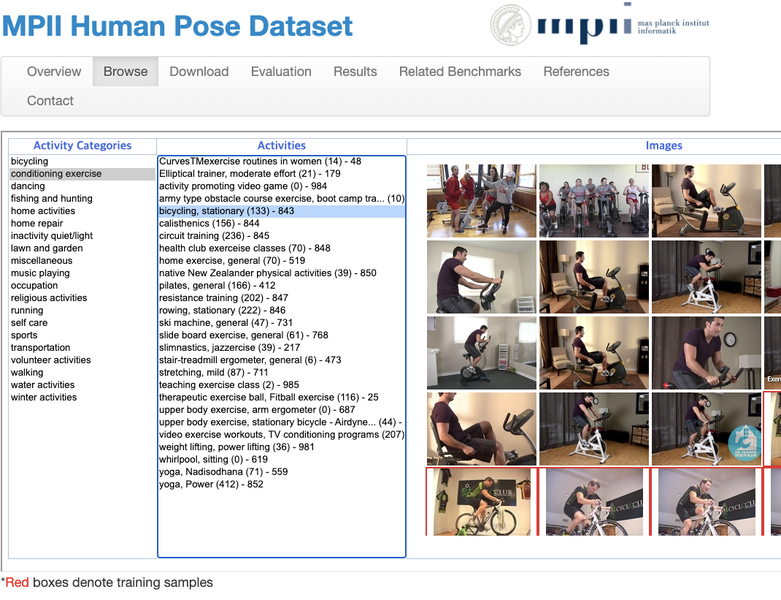
http://human-pose.mpi-inf.mpg.de/#download  

미리 준비해 둔 데이터를 연결하고 압축을 해제해 주세요.
```bash
$ mkdir -p ~/aiffel/mpii
$ ln -s ~/data/* ~/aiffel/mpii
$ cd ~/aiffel/mpii
$ tar -xvf mpii_human_pose_v1.tar.gz -C . 
$ unzip mpii_human_pose_v1_u12_2.zip
```

mpii_human_pose_v1_u12_2.zip 을 풀어보면 mpii_human_pose_v1_u12_1.mat 파일이 나와서 열어보기 불편한데요. 파이썬에서 읽기 쉽도록 json 파일로 변환해 두었습니다.

```bash
$ cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json
```

mpii.zip
마지막으로, 오늘의 실습 코드를 프로젝트로 구성한 파일을 압축 해제합니다.

```bash
$ cd ~/aiffel/mpii && unzip mpii.zip
```

이번 노드에서는 이 프로젝트 파일을 LMS환경에 맞게 편집하여 진행합니다. .py 파일 원본을 확인하면 학습에 도움이 되실거예요.

In [2]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

MODEL_CUSTOM_PATH = os.path.join(PROJECT_PATH, 'models_custom')
print('슝=3')

슝=3


In [3]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.applications import ResNet50

In [4]:
EPOCHS = 1
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

### 데이터 전처리

#### json 파싱

In [5]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [6]:
# json annotation 파싱 함수
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [7]:
# parse_one_annotation 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [8]:
# TFRecord로 변환하는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [9]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [10]:
# 하나의 chunk를 TFRecord로 만들어 주는 함수
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [11]:
# 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다. 시간이 꽤 걸립니다.

In [12]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-01-03 07:12:48,736	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.77gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=421) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=421) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=423) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=423) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=422) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=422) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=423) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=423) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=421) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=421) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=422) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=422) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=423) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=423) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=421) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=421) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

### data label 로 만들기

In [13]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


### 평가 지표 구현

#### mAP

In [14]:
class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, name='mAP', threshold=0.5, **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.total_ground_truths = self.add_weight(name='gt', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        oks = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))
        correct_keypoints = tf.cast(oks < self.threshold, tf.float32)
        
        self.true_positives.assign_add(tf.reduce_sum(correct_keypoints))
        self.false_positives.assign_add(tf.reduce_sum(1 - correct_keypoints))
        self.total_ground_truths.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.total_ground_truths + 1e-7)
        return (precision + recall) / 2

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.total_ground_truths.assign(0)

#### PCHK-0.5

In [15]:
class PCKh(tf.keras.metrics.Metric):
    def __init__(self, name='PCKh-0.5', threshold=0.5, **kwargs):
        super(PCKh, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.correct_keypoints = self.add_weight(name='correct', initializer='zeros')
        self.total_keypoints = self.add_weight(name='total', initializer='zeros')
    
    def update_state(self, y_true, y_pred, head_length, sample_weight=None):
        distances = tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1))
        normalized_distances = distances / head_length
        correct = tf.cast(normalized_distances < self.threshold, tf.float32)
        
        self.correct_keypoints.assign_add(tf.reduce_sum(correct))
        self.total_keypoints.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.correct_keypoints / (self.total_keypoints + 1e-7)
    
    def reset_states(self):
        self.correct_keypoints.assign(0)
        self.total_keypoints.assign(0)

### Hourglass 모델 만들기

In [16]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [17]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [18]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [19]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


### 학습 엔진 만들기
- GPU 가 여러 개인 환경
- loss 와 학습률 시각화 기능 추가
- SimpleBaseline에 맞게 outputs 이 단일 텐서일 경우도 처리하도록 코드를 보완
    - Hourglass 모델 출력: 여러 단계에서 히트맵이 출력됨 → outputs는 리스트 형태로 여러 히트맵을 포함
	- SimpleBaseline 모델 출력: 마지막 히트맵만 출력됨 → outputs는 단일 텐서
- 평가 지표 추가하기(mAP, PCKh-0.5)

In [16]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        # 추가: mAP와 PCKh-0.5 메트릭 초기화
        self.map_metric = MeanAveragePrecision(threshold=0.5)
        self.pckh_metric = PCKh(threshold=0.5)
        
        # mAP 및 PCKh 기록
        self.train_map = []  # Train mAP 기록
        self.val_map = []    # Val mAP 기록
        self.train_pckh = []  # Train PCKh 기록
        self.val_pckh = []    # Val PCKh 기록
        
        # 추가됨: 손실 및 학습률을 기록하기 위한 리스트
        self.train_losses = []  # Train Loss 기록
        self.val_losses = []    # Validation Loss 기록
        self.learning_rates = []  # Learning Rate 기록

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        
        # 추가됨: outputs를 리스트로 강제 변환
        if not isinstance(outputs, list):
            outputs = [outputs]
        
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))
        
        # 추가됨 : 메트릭 업데이트
        self.map_metric.update_state(labels, outputs)
        self.pckh_metric.update_state(labels, outputs, head_length=1.0)  # Head Length는 데이터셋에 맞게 조정 필요
        
        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        
        # 메트릭 업데이트
        self.map_metric.update_state(labels, outputs)
        self.pckh_metric.update_state(labels, outputs, head_length=1.0)  # Head Length는 데이터셋에 맞게 조정 필요
        
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            # 추가됨 메트릭 기록
            print('Epoch {} train loss {}, mAP {}, PCKh {}'.format(
                epoch, train_loss, self.map_metric.result(), self.pckh_metric.result()
            ))
            print('Epoch {} val loss {}, mAP {}, PCKh {}'.format(
                epoch, val_loss, self.map_metric.result(), self.pckh_metric.result()
            ))
            self.train_map.append(self.map_metric.result().numpy())
            self.val_map.append(self.map_metric.result().numpy())
            self.train_pckh.append(self.pckh_metric.result().numpy())
            self.val_pckh.append(self.pckh_metric.result().numpy())
            
            # 추가됨: 손실 및 학습률 기록
            self.train_losses.append(train_loss.numpy())  # Train Loss 기록
            self.val_losses.append(val_loss.numpy())      # Validation Loss 기록
            self.learning_rates.append(self.current_learning_rate)  # Learning Rate 기록

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        # 추가됨: 학습 종료 후 시각화
        self.plot_metrics()
        
        return self.best_model

#     def save_model(self, epoch, loss):
#         model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
#         self.model.save_weights(model_name)
#         self.best_model = model_name
#         print("Model {} saved.".format(model_name))

    def save_model(self, epoch, loss):
        """
        모델을 저장할 때 StackedHourglassNetwork와 SimpleBaseline에 따라 파일 이름을 구분
        """
        # 모델 타입 확인
        model_type = self.model.name if hasattr(self.model, 'name') else 'unknown_model'

        # 저장 경로 및 파일명 설정
        # MODEL_PATH 는 쓰기 권한 문제로 MODEL_CUSTOM_PATH 로 변경
        model_name = f"{MODEL_CUSTOM_PATH}/{model_type}-epoch-{epoch}-loss-{loss:.4f}.h5"

        # 모델 저장
        self.model.save_weights(model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")
    
    # 추가됨: 시각화 함수
    def plot_metrics(self):
        """학습 손실, 검증 손실, 학습률을 시각화합니다."""
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(16, 5))

        # Train Loss vs Val Loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Learning Rate
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.learning_rates, label='Learning Rate', color='orange')
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        
        # Train mAP vs Val mAP
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_map, label='Train mAP')
        plt.plot(epochs, self.val_map, label='Val mAP')
        plt.plot(epochs, self.train_pckh, label='Train PCKh')
        plt.plot(epochs, self.val_pckh, label='Val PCKh')
        plt.title('mAP and PCKh')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [17]:
# 데이터셋 make 함수
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

데이터셋과 모델, 훈련용 객체를 조립만하면 되겠군요. 주의할 점은 with strategy.scope():부분이 반드시 필요하다는 점이에요. 또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요해요.

In [23]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_CUSTOM_PATH):
        os.makedirs(MODEL_CUSTOM_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.64991331 epoch total loss 2.64991331
Trained batch 2 batch loss 2.3493402 epoch total loss 2.49962664
Trained batch 3 batch loss 2.41462469 epoch total loss 2.47129273
Trained batch 4 batch loss 2.52421951 epoch total loss 2.48452425
Trained batch 5 batch loss 2.43789721 epoch total loss 2.47519875
Trained batch 6 batch loss 2.38405347 epoch total loss 2.46000791
Trained batch 7 batch loss 2.34330106 epoch total loss 2.44333529
Trained batch 8 batch loss 2.21947432 epoch total loss 2.41535282
Trained batch 9 batch loss 2.14531684 epoch total loss 2.3853488
Trained batch 10 batch loss 2.1314249 epoch total loss 2.35995626
Trained batch 11 batch loss 2.12889266 epoch total loss 2.33895063
Trained batch 12 batch loss 1.94987154 epoch total loss 2.30652738
Trained batch 13 

Trained batch 121 batch loss 1.6640209 epoch total loss 1.82158375
Trained batch 122 batch loss 1.65398204 epoch total loss 1.82021
Trained batch 123 batch loss 1.74942517 epoch total loss 1.81963444
Trained batch 124 batch loss 1.75195444 epoch total loss 1.81908858
Trained batch 125 batch loss 1.75676513 epoch total loss 1.81858993
Trained batch 126 batch loss 1.85847497 epoch total loss 1.81890655
Trained batch 127 batch loss 1.81263423 epoch total loss 1.81885719
Trained batch 128 batch loss 1.80725622 epoch total loss 1.81876647
Trained batch 129 batch loss 1.7154851 epoch total loss 1.81796587
Trained batch 130 batch loss 1.69811249 epoch total loss 1.81704378
Trained batch 131 batch loss 1.75816083 epoch total loss 1.81659436
Trained batch 132 batch loss 1.79098129 epoch total loss 1.81640041
Trained batch 133 batch loss 1.81266546 epoch total loss 1.81637228
Trained batch 134 batch loss 1.59288192 epoch total loss 1.81470442
Trained batch 135 batch loss 1.71961415 epoch total l

Trained batch 243 batch loss 1.52069426 epoch total loss 1.72548079
Trained batch 244 batch loss 1.63164961 epoch total loss 1.72509623
Trained batch 245 batch loss 1.6206224 epoch total loss 1.72466993
Trained batch 246 batch loss 1.63158941 epoch total loss 1.72429156
Trained batch 247 batch loss 1.65084922 epoch total loss 1.72399426
Trained batch 248 batch loss 1.63274503 epoch total loss 1.72362626
Trained batch 249 batch loss 1.60754907 epoch total loss 1.72316015
Trained batch 250 batch loss 1.54225183 epoch total loss 1.72243655
Trained batch 251 batch loss 1.53898048 epoch total loss 1.72170556
Trained batch 252 batch loss 1.55211103 epoch total loss 1.72103262
Trained batch 253 batch loss 1.60938072 epoch total loss 1.72059131
Trained batch 254 batch loss 1.6604687 epoch total loss 1.72035456
Trained batch 255 batch loss 1.586272 epoch total loss 1.71982872
Trained batch 256 batch loss 1.72116256 epoch total loss 1.71983397
Trained batch 257 batch loss 1.61133409 epoch total 

Trained batch 365 batch loss 1.50460684 epoch total loss 1.68042564
Trained batch 366 batch loss 1.59496212 epoch total loss 1.68019211
Trained batch 367 batch loss 1.6065048 epoch total loss 1.67999136
Trained batch 368 batch loss 1.52229202 epoch total loss 1.67956281
Trained batch 369 batch loss 1.55089617 epoch total loss 1.67921412
Trained batch 370 batch loss 1.55056357 epoch total loss 1.67886639
Trained batch 371 batch loss 1.51144791 epoch total loss 1.67841518
Trained batch 372 batch loss 1.59741366 epoch total loss 1.67819738
Trained batch 373 batch loss 1.57223153 epoch total loss 1.67791319
Trained batch 374 batch loss 1.44061208 epoch total loss 1.67727876
Trained batch 375 batch loss 1.47469878 epoch total loss 1.6767385
Trained batch 376 batch loss 1.64263225 epoch total loss 1.67664778
Trained batch 377 batch loss 1.61499083 epoch total loss 1.67648423
Trained batch 378 batch loss 1.63209045 epoch total loss 1.67636669
Trained batch 379 batch loss 1.56344414 epoch tota

Trained batch 486 batch loss 1.57174575 epoch total loss 1.65365601
Trained batch 487 batch loss 1.55424333 epoch total loss 1.65345192
Trained batch 488 batch loss 1.55549884 epoch total loss 1.65325117
Trained batch 489 batch loss 1.58300662 epoch total loss 1.65310752
Trained batch 490 batch loss 1.56396937 epoch total loss 1.65292561
Trained batch 491 batch loss 1.43333054 epoch total loss 1.65247834
Trained batch 492 batch loss 1.45149839 epoch total loss 1.65206981
Trained batch 493 batch loss 1.36722505 epoch total loss 1.65149212
Trained batch 494 batch loss 1.38760436 epoch total loss 1.65095794
Trained batch 495 batch loss 1.50535476 epoch total loss 1.65066385
Trained batch 496 batch loss 1.62703145 epoch total loss 1.65061617
Trained batch 497 batch loss 1.6518116 epoch total loss 1.65061855
Trained batch 498 batch loss 1.66606855 epoch total loss 1.65064955
Trained batch 499 batch loss 1.58422256 epoch total loss 1.65051651
Trained batch 500 batch loss 1.56976247 epoch tot

Trained batch 607 batch loss 1.60912609 epoch total loss 1.63370287
Trained batch 608 batch loss 1.57057083 epoch total loss 1.63359904
Trained batch 609 batch loss 1.61545193 epoch total loss 1.63356924
Trained batch 610 batch loss 1.70245421 epoch total loss 1.63368225
Trained batch 611 batch loss 1.72472739 epoch total loss 1.63383126
Trained batch 612 batch loss 1.64489985 epoch total loss 1.63384926
Trained batch 613 batch loss 1.63758874 epoch total loss 1.63385534
Trained batch 614 batch loss 1.57613158 epoch total loss 1.63376129
Trained batch 615 batch loss 1.49494624 epoch total loss 1.63353562
Trained batch 616 batch loss 1.57726204 epoch total loss 1.63344431
Trained batch 617 batch loss 1.63290203 epoch total loss 1.63344336
Trained batch 618 batch loss 1.62693095 epoch total loss 1.63343287
Trained batch 619 batch loss 1.47591829 epoch total loss 1.63317835
Trained batch 620 batch loss 1.54498827 epoch total loss 1.63303602
Trained batch 621 batch loss 1.5341444 epoch tot

Trained batch 729 batch loss 1.29144931 epoch total loss 1.61935401
Trained batch 730 batch loss 1.2477386 epoch total loss 1.61884487
Trained batch 731 batch loss 1.21412361 epoch total loss 1.61829114
Trained batch 732 batch loss 1.35154593 epoch total loss 1.61792672
Trained batch 733 batch loss 1.47435522 epoch total loss 1.61773086
Trained batch 734 batch loss 1.61988163 epoch total loss 1.61773384
Trained batch 735 batch loss 1.50115418 epoch total loss 1.61757517
Trained batch 736 batch loss 1.43502 epoch total loss 1.61732709
Trained batch 737 batch loss 1.54620838 epoch total loss 1.61723077
Trained batch 738 batch loss 1.62211847 epoch total loss 1.61723733
Trained batch 739 batch loss 1.50619483 epoch total loss 1.61708713
Trained batch 740 batch loss 1.60057 epoch total loss 1.61706471
Trained batch 741 batch loss 1.72262263 epoch total loss 1.61720729
Trained batch 742 batch loss 1.72395492 epoch total loss 1.61735117
Trained batch 743 batch loss 1.59719634 epoch total los

Trained batch 851 batch loss 1.35021186 epoch total loss 1.60423577
Trained batch 852 batch loss 1.38719201 epoch total loss 1.60398102
Trained batch 853 batch loss 1.39316583 epoch total loss 1.6037339
Trained batch 854 batch loss 1.31370139 epoch total loss 1.60339427
Trained batch 855 batch loss 1.4359901 epoch total loss 1.60319853
Trained batch 856 batch loss 1.5248332 epoch total loss 1.60310698
Trained batch 857 batch loss 1.55462742 epoch total loss 1.60305047
Trained batch 858 batch loss 1.49188781 epoch total loss 1.60292089
Trained batch 859 batch loss 1.35748386 epoch total loss 1.60263526
Trained batch 860 batch loss 1.49672735 epoch total loss 1.60251212
Trained batch 861 batch loss 1.50574088 epoch total loss 1.60239971
Trained batch 862 batch loss 1.48568797 epoch total loss 1.60226429
Trained batch 863 batch loss 1.51917672 epoch total loss 1.60216808
Trained batch 864 batch loss 1.41719139 epoch total loss 1.60195398
Trained batch 865 batch loss 1.42714012 epoch total

Trained batch 972 batch loss 1.44161236 epoch total loss 1.58811164
Trained batch 973 batch loss 1.48708975 epoch total loss 1.58800781
Trained batch 974 batch loss 1.50099957 epoch total loss 1.5879184
Trained batch 975 batch loss 1.48204875 epoch total loss 1.58780992
Trained batch 976 batch loss 1.57395351 epoch total loss 1.58779573
Trained batch 977 batch loss 1.6695857 epoch total loss 1.58787942
Trained batch 978 batch loss 1.53374672 epoch total loss 1.58782399
Trained batch 979 batch loss 1.5316062 epoch total loss 1.58776653
Trained batch 980 batch loss 1.54129136 epoch total loss 1.58771908
Trained batch 981 batch loss 1.56412828 epoch total loss 1.587695
Trained batch 982 batch loss 1.52907944 epoch total loss 1.58763528
Trained batch 983 batch loss 1.44521523 epoch total loss 1.58749044
Trained batch 984 batch loss 1.48012352 epoch total loss 1.58738124
Trained batch 985 batch loss 1.42585218 epoch total loss 1.58721733
Trained batch 986 batch loss 1.52788293 epoch total l

Trained batch 1092 batch loss 1.49363351 epoch total loss 1.57737803
Trained batch 1093 batch loss 1.47524607 epoch total loss 1.57728457
Trained batch 1094 batch loss 1.47859287 epoch total loss 1.57719445
Trained batch 1095 batch loss 1.39179206 epoch total loss 1.57702518
Trained batch 1096 batch loss 1.52144706 epoch total loss 1.57697451
Trained batch 1097 batch loss 1.45580447 epoch total loss 1.576864
Trained batch 1098 batch loss 1.52324545 epoch total loss 1.57681513
Trained batch 1099 batch loss 1.46948779 epoch total loss 1.5767175
Trained batch 1100 batch loss 1.39425063 epoch total loss 1.57655168
Trained batch 1101 batch loss 1.46148717 epoch total loss 1.57644713
Trained batch 1102 batch loss 1.39447832 epoch total loss 1.57628214
Trained batch 1103 batch loss 1.4369899 epoch total loss 1.57615578
Trained batch 1104 batch loss 1.46785021 epoch total loss 1.57605779
Trained batch 1105 batch loss 1.36744475 epoch total loss 1.57586896
Trained batch 1106 batch loss 1.385565

Trained batch 1212 batch loss 1.44382417 epoch total loss 1.56704175
Trained batch 1213 batch loss 1.44018316 epoch total loss 1.56693721
Trained batch 1214 batch loss 1.42907381 epoch total loss 1.5668236
Trained batch 1215 batch loss 1.4711206 epoch total loss 1.5667448
Trained batch 1216 batch loss 1.42604411 epoch total loss 1.56662905
Trained batch 1217 batch loss 1.53571689 epoch total loss 1.56660378
Trained batch 1218 batch loss 1.52968 epoch total loss 1.56657338
Trained batch 1219 batch loss 1.42533898 epoch total loss 1.56645751
Trained batch 1220 batch loss 1.42378163 epoch total loss 1.56634057
Trained batch 1221 batch loss 1.3907 epoch total loss 1.5661968
Trained batch 1222 batch loss 1.45751607 epoch total loss 1.56610787
Trained batch 1223 batch loss 1.38423526 epoch total loss 1.56595922
Trained batch 1224 batch loss 1.53776813 epoch total loss 1.56593609
Trained batch 1225 batch loss 1.56596386 epoch total loss 1.56593609
Trained batch 1226 batch loss 1.50016236 epoc

Trained batch 1332 batch loss 1.25926208 epoch total loss 1.5574497
Trained batch 1333 batch loss 1.30039585 epoch total loss 1.5572567
Trained batch 1334 batch loss 1.36178398 epoch total loss 1.55711019
Trained batch 1335 batch loss 1.3547318 epoch total loss 1.55695868
Trained batch 1336 batch loss 1.20363581 epoch total loss 1.55669415
Trained batch 1337 batch loss 1.19109368 epoch total loss 1.5564208
Trained batch 1338 batch loss 1.22218895 epoch total loss 1.55617094
Trained batch 1339 batch loss 1.34638023 epoch total loss 1.5560143
Trained batch 1340 batch loss 1.45982099 epoch total loss 1.55594242
Trained batch 1341 batch loss 1.41981113 epoch total loss 1.55584097
Trained batch 1342 batch loss 1.50958383 epoch total loss 1.55580652
Trained batch 1343 batch loss 1.58687031 epoch total loss 1.55582964
Trained batch 1344 batch loss 1.49691629 epoch total loss 1.55578578
Trained batch 1345 batch loss 1.49717104 epoch total loss 1.55574214
Trained batch 1346 batch loss 1.3910245

Validated batch 105 batch loss 1.40864468
Validated batch 106 batch loss 1.37871873
Validated batch 107 batch loss 1.41866183
Validated batch 108 batch loss 1.45422721
Validated batch 109 batch loss 1.43607235
Validated batch 110 batch loss 1.49750662
Validated batch 111 batch loss 1.57169509
Validated batch 112 batch loss 1.67299592
Validated batch 113 batch loss 1.60030591
Validated batch 114 batch loss 1.46123409
Validated batch 115 batch loss 1.35594404
Validated batch 116 batch loss 1.37777305
Validated batch 117 batch loss 1.49569631
Validated batch 118 batch loss 1.42659712
Validated batch 119 batch loss 1.28300118
Validated batch 120 batch loss 1.34414363
Validated batch 121 batch loss 1.55432868
Validated batch 122 batch loss 1.37534845
Validated batch 123 batch loss 1.38926792
Validated batch 124 batch loss 1.45711112
Validated batch 125 batch loss 1.4701823
Validated batch 126 batch loss 1.40861738
Validated batch 127 batch loss 1.48335314
Validated batch 128 batch loss 1.43

Trained batch 71 batch loss 1.46919525 epoch total loss 1.43999052
Trained batch 72 batch loss 1.49528658 epoch total loss 1.44075847
Trained batch 73 batch loss 1.54431605 epoch total loss 1.44217718
Trained batch 74 batch loss 1.52569139 epoch total loss 1.44330561
Trained batch 75 batch loss 1.45313203 epoch total loss 1.44343674
Trained batch 76 batch loss 1.46144629 epoch total loss 1.44367373
Trained batch 77 batch loss 1.38961101 epoch total loss 1.44297159
Trained batch 78 batch loss 1.42478132 epoch total loss 1.44273841
Trained batch 79 batch loss 1.56942439 epoch total loss 1.44434202
Trained batch 80 batch loss 1.372244 epoch total loss 1.44344079
Trained batch 81 batch loss 1.38415909 epoch total loss 1.44270885
Trained batch 82 batch loss 1.35273349 epoch total loss 1.44161165
Trained batch 83 batch loss 1.35644937 epoch total loss 1.44058561
Trained batch 84 batch loss 1.36840725 epoch total loss 1.43972635
Trained batch 85 batch loss 1.38116169 epoch total loss 1.439037

Trained batch 193 batch loss 1.52165365 epoch total loss 1.44332
Trained batch 194 batch loss 1.38380182 epoch total loss 1.44301319
Trained batch 195 batch loss 1.38685799 epoch total loss 1.44272518
Trained batch 196 batch loss 1.46826577 epoch total loss 1.44285548
Trained batch 197 batch loss 1.43484628 epoch total loss 1.44281483
Trained batch 198 batch loss 1.33380961 epoch total loss 1.44226432
Trained batch 199 batch loss 1.40956652 epoch total loss 1.4421
Trained batch 200 batch loss 1.36666691 epoch total loss 1.44172287
Trained batch 201 batch loss 1.30127788 epoch total loss 1.44102407
Trained batch 202 batch loss 1.27833462 epoch total loss 1.44021869
Trained batch 203 batch loss 1.34538865 epoch total loss 1.43975151
Trained batch 204 batch loss 1.37871361 epoch total loss 1.43945241
Trained batch 205 batch loss 1.3531909 epoch total loss 1.43903148
Trained batch 206 batch loss 1.30717802 epoch total loss 1.43839157
Trained batch 207 batch loss 1.32897258 epoch total loss

Trained batch 314 batch loss 1.47220826 epoch total loss 1.43418229
Trained batch 315 batch loss 1.38744831 epoch total loss 1.43403399
Trained batch 316 batch loss 1.46357226 epoch total loss 1.43412745
Trained batch 317 batch loss 1.4289248 epoch total loss 1.434111
Trained batch 318 batch loss 1.38726 epoch total loss 1.43396366
Trained batch 319 batch loss 1.4230715 epoch total loss 1.43392956
Trained batch 320 batch loss 1.37620807 epoch total loss 1.4337492
Trained batch 321 batch loss 1.36063588 epoch total loss 1.43352139
Trained batch 322 batch loss 1.32213926 epoch total loss 1.43317556
Trained batch 323 batch loss 1.33809233 epoch total loss 1.43288112
Trained batch 324 batch loss 1.3442049 epoch total loss 1.43260753
Trained batch 325 batch loss 1.46392655 epoch total loss 1.43270385
Trained batch 326 batch loss 1.43373084 epoch total loss 1.43270695
Trained batch 327 batch loss 1.38689017 epoch total loss 1.43256688
Trained batch 328 batch loss 1.32541502 epoch total loss 

Trained batch 435 batch loss 1.42343068 epoch total loss 1.42109728
Trained batch 436 batch loss 1.41023767 epoch total loss 1.42107224
Trained batch 437 batch loss 1.33161247 epoch total loss 1.42086756
Trained batch 438 batch loss 1.36172736 epoch total loss 1.42073262
Trained batch 439 batch loss 1.30658412 epoch total loss 1.42047262
Trained batch 440 batch loss 1.30760527 epoch total loss 1.42021608
Trained batch 441 batch loss 1.43650174 epoch total loss 1.42025304
Trained batch 442 batch loss 1.45789027 epoch total loss 1.42033815
Trained batch 443 batch loss 1.60603166 epoch total loss 1.42075741
Trained batch 444 batch loss 1.59549749 epoch total loss 1.42115092
Trained batch 445 batch loss 1.52678728 epoch total loss 1.42138839
Trained batch 446 batch loss 1.45388889 epoch total loss 1.42146134
Trained batch 447 batch loss 1.38129282 epoch total loss 1.42137146
Trained batch 448 batch loss 1.30921936 epoch total loss 1.421121
Trained batch 449 batch loss 1.36556387 epoch tota

Trained batch 557 batch loss 1.30990577 epoch total loss 1.41470563
Trained batch 558 batch loss 1.26377666 epoch total loss 1.41443515
Trained batch 559 batch loss 1.39574468 epoch total loss 1.41440177
Trained batch 560 batch loss 1.42433202 epoch total loss 1.41441941
Trained batch 561 batch loss 1.35626924 epoch total loss 1.41431582
Trained batch 562 batch loss 1.3119061 epoch total loss 1.41413355
Trained batch 563 batch loss 1.28313828 epoch total loss 1.41390085
Trained batch 564 batch loss 1.41917253 epoch total loss 1.41391027
Trained batch 565 batch loss 1.38245845 epoch total loss 1.4138546
Trained batch 566 batch loss 1.34863734 epoch total loss 1.41373932
Trained batch 567 batch loss 1.5544548 epoch total loss 1.41398752
Trained batch 568 batch loss 1.24738336 epoch total loss 1.41369414
Trained batch 569 batch loss 1.32171535 epoch total loss 1.4135325
Trained batch 570 batch loss 1.37718606 epoch total loss 1.41346872
Trained batch 571 batch loss 1.19161165 epoch total 

Trained batch 678 batch loss 1.39285803 epoch total loss 1.40438271
Trained batch 679 batch loss 1.36627233 epoch total loss 1.40432656
Trained batch 680 batch loss 1.33543265 epoch total loss 1.40422523
Trained batch 681 batch loss 1.34332478 epoch total loss 1.40413582
Trained batch 682 batch loss 1.28577042 epoch total loss 1.40396225
Trained batch 683 batch loss 1.46098304 epoch total loss 1.40404582
Trained batch 684 batch loss 1.37678301 epoch total loss 1.40400589
Trained batch 685 batch loss 1.50884271 epoch total loss 1.40415895
Trained batch 686 batch loss 1.58298445 epoch total loss 1.40441966
Trained batch 687 batch loss 1.54431403 epoch total loss 1.40462327
Trained batch 688 batch loss 1.6108228 epoch total loss 1.40492296
Trained batch 689 batch loss 1.38741124 epoch total loss 1.40489757
Trained batch 690 batch loss 1.25218105 epoch total loss 1.40467632
Trained batch 691 batch loss 1.45538735 epoch total loss 1.40474963
Trained batch 692 batch loss 1.51411331 epoch tot

Trained batch 800 batch loss 1.43698072 epoch total loss 1.4017539
Trained batch 801 batch loss 1.30014825 epoch total loss 1.40162706
Trained batch 802 batch loss 1.20951533 epoch total loss 1.40138745
Trained batch 803 batch loss 1.34875274 epoch total loss 1.40132189
Trained batch 804 batch loss 1.33927584 epoch total loss 1.40124464
Trained batch 805 batch loss 1.50207651 epoch total loss 1.40136993
Trained batch 806 batch loss 1.34956753 epoch total loss 1.40130568
Trained batch 807 batch loss 1.5657562 epoch total loss 1.40150952
Trained batch 808 batch loss 1.65013659 epoch total loss 1.4018172
Trained batch 809 batch loss 1.53513646 epoch total loss 1.40198207
Trained batch 810 batch loss 1.35478568 epoch total loss 1.40192378
Trained batch 811 batch loss 1.36934805 epoch total loss 1.4018836
Trained batch 812 batch loss 1.12007976 epoch total loss 1.40153658
Trained batch 813 batch loss 1.24519038 epoch total loss 1.40134442
Trained batch 814 batch loss 1.29962194 epoch total 

Trained batch 921 batch loss 1.31323934 epoch total loss 1.39739895
Trained batch 922 batch loss 1.37987363 epoch total loss 1.39737988
Trained batch 923 batch loss 1.22949111 epoch total loss 1.39719796
Trained batch 924 batch loss 1.19786012 epoch total loss 1.39698231
Trained batch 925 batch loss 1.2921648 epoch total loss 1.39686894
Trained batch 926 batch loss 1.37529278 epoch total loss 1.39684558
Trained batch 927 batch loss 1.43326187 epoch total loss 1.3968848
Trained batch 928 batch loss 1.27123439 epoch total loss 1.39674938
Trained batch 929 batch loss 1.28832579 epoch total loss 1.39663267
Trained batch 930 batch loss 1.30779529 epoch total loss 1.39653718
Trained batch 931 batch loss 1.34916437 epoch total loss 1.39648616
Trained batch 932 batch loss 1.25427651 epoch total loss 1.39633358
Trained batch 933 batch loss 1.30350137 epoch total loss 1.39623404
Trained batch 934 batch loss 1.29408574 epoch total loss 1.39612472
Trained batch 935 batch loss 1.42845726 epoch tota

Trained batch 1042 batch loss 1.37587535 epoch total loss 1.39119041
Trained batch 1043 batch loss 1.40854204 epoch total loss 1.39120698
Trained batch 1044 batch loss 1.21353602 epoch total loss 1.39103687
Trained batch 1045 batch loss 1.25335097 epoch total loss 1.39090502
Trained batch 1046 batch loss 1.22932374 epoch total loss 1.39075053
Trained batch 1047 batch loss 1.27732658 epoch total loss 1.39064229
Trained batch 1048 batch loss 1.26748061 epoch total loss 1.39052474
Trained batch 1049 batch loss 1.19978702 epoch total loss 1.39034295
Trained batch 1050 batch loss 1.29470444 epoch total loss 1.39025176
Trained batch 1051 batch loss 1.30599749 epoch total loss 1.39017165
Trained batch 1052 batch loss 1.31564307 epoch total loss 1.39010084
Trained batch 1053 batch loss 1.31217837 epoch total loss 1.39002681
Trained batch 1054 batch loss 1.24383259 epoch total loss 1.38988805
Trained batch 1055 batch loss 1.3538022 epoch total loss 1.38985384
Trained batch 1056 batch loss 1.352

Trained batch 1161 batch loss 1.29614878 epoch total loss 1.38516617
Trained batch 1162 batch loss 1.20710731 epoch total loss 1.38501298
Trained batch 1163 batch loss 1.55506706 epoch total loss 1.38515925
Trained batch 1164 batch loss 1.50565684 epoch total loss 1.38526273
Trained batch 1165 batch loss 1.3807478 epoch total loss 1.38525879
Trained batch 1166 batch loss 1.43743491 epoch total loss 1.3853035
Trained batch 1167 batch loss 1.57070184 epoch total loss 1.3854624
Trained batch 1168 batch loss 1.35376191 epoch total loss 1.38543522
Trained batch 1169 batch loss 1.3974756 epoch total loss 1.38544548
Trained batch 1170 batch loss 1.3421731 epoch total loss 1.38540852
Trained batch 1171 batch loss 1.27343202 epoch total loss 1.38531291
Trained batch 1172 batch loss 1.31884193 epoch total loss 1.38525617
Trained batch 1173 batch loss 1.29990184 epoch total loss 1.38518345
Trained batch 1174 batch loss 1.29918516 epoch total loss 1.38511026
Trained batch 1175 batch loss 1.3344599

Trained batch 1281 batch loss 1.26772451 epoch total loss 1.38131607
Trained batch 1282 batch loss 1.28366184 epoch total loss 1.38123989
Trained batch 1283 batch loss 1.30447817 epoch total loss 1.38118
Trained batch 1284 batch loss 1.26371193 epoch total loss 1.3810885
Trained batch 1285 batch loss 1.26873565 epoch total loss 1.381001
Trained batch 1286 batch loss 1.35505462 epoch total loss 1.38098085
Trained batch 1287 batch loss 1.2214756 epoch total loss 1.38085687
Trained batch 1288 batch loss 1.11286092 epoch total loss 1.38064885
Trained batch 1289 batch loss 1.05924952 epoch total loss 1.38039947
Trained batch 1290 batch loss 1.14004683 epoch total loss 1.38021314
Trained batch 1291 batch loss 1.32603514 epoch total loss 1.38017118
Trained batch 1292 batch loss 1.32131565 epoch total loss 1.38012564
Trained batch 1293 batch loss 1.45697379 epoch total loss 1.38018513
Trained batch 1294 batch loss 1.32771659 epoch total loss 1.3801446
Trained batch 1295 batch loss 1.35868132 e

Validated batch 20 batch loss 1.18654084
Validated batch 21 batch loss 1.34190416
Validated batch 22 batch loss 1.3999393
Validated batch 23 batch loss 1.22717083
Validated batch 24 batch loss 1.30399215
Validated batch 25 batch loss 1.28760457
Validated batch 26 batch loss 1.31336927
Validated batch 27 batch loss 1.23755598
Validated batch 28 batch loss 1.23182523
Validated batch 29 batch loss 1.38150632
Validated batch 30 batch loss 1.30283558
Validated batch 31 batch loss 1.18529415
Validated batch 32 batch loss 1.25160897
Validated batch 33 batch loss 1.2754283
Validated batch 34 batch loss 1.27043152
Validated batch 35 batch loss 1.26863027
Validated batch 36 batch loss 1.32938552
Validated batch 37 batch loss 1.31395936
Validated batch 38 batch loss 1.40567672
Validated batch 39 batch loss 1.39665079
Validated batch 40 batch loss 1.32845879
Validated batch 41 batch loss 1.40077162
Validated batch 42 batch loss 1.14436626
Validated batch 43 batch loss 1.29652894
Validated batch 44

Trained batch 18 batch loss 1.47415411 epoch total loss 1.37430954
Trained batch 19 batch loss 1.40073705 epoch total loss 1.37570047
Trained batch 20 batch loss 1.26930082 epoch total loss 1.37038052
Trained batch 21 batch loss 1.17691243 epoch total loss 1.36116767
Trained batch 22 batch loss 1.19284558 epoch total loss 1.3535167
Trained batch 23 batch loss 1.20223498 epoch total loss 1.34693921
Trained batch 24 batch loss 1.21673667 epoch total loss 1.34151411
Trained batch 25 batch loss 1.25558186 epoch total loss 1.33807683
Trained batch 26 batch loss 1.43262076 epoch total loss 1.34171307
Trained batch 27 batch loss 1.28829789 epoch total loss 1.33973479
Trained batch 28 batch loss 1.33109534 epoch total loss 1.33942628
Trained batch 29 batch loss 1.31140447 epoch total loss 1.33846009
Trained batch 30 batch loss 1.30173588 epoch total loss 1.33723593
Trained batch 31 batch loss 1.38246679 epoch total loss 1.33869493
Trained batch 32 batch loss 1.37833285 epoch total loss 1.33993

Trained batch 141 batch loss 1.17731261 epoch total loss 1.31364906
Trained batch 142 batch loss 1.20236206 epoch total loss 1.31286538
Trained batch 143 batch loss 1.3535831 epoch total loss 1.31315
Trained batch 144 batch loss 1.38962245 epoch total loss 1.31368113
Trained batch 145 batch loss 1.31958854 epoch total loss 1.3137219
Trained batch 146 batch loss 1.21596837 epoch total loss 1.3130523
Trained batch 147 batch loss 1.36925721 epoch total loss 1.31343472
Trained batch 148 batch loss 1.3703686 epoch total loss 1.31381941
Trained batch 149 batch loss 1.20723605 epoch total loss 1.31310403
Trained batch 150 batch loss 1.21632743 epoch total loss 1.31245875
Trained batch 151 batch loss 1.48265946 epoch total loss 1.313586
Trained batch 152 batch loss 1.3882935 epoch total loss 1.3140775
Trained batch 153 batch loss 1.35437965 epoch total loss 1.31434095
Trained batch 154 batch loss 1.34199977 epoch total loss 1.31452048
Trained batch 155 batch loss 1.16666007 epoch total loss 1.

Trained batch 263 batch loss 1.40609336 epoch total loss 1.31947351
Trained batch 264 batch loss 1.32489216 epoch total loss 1.31949413
Trained batch 265 batch loss 1.29961586 epoch total loss 1.31941903
Trained batch 266 batch loss 1.24784541 epoch total loss 1.31915
Trained batch 267 batch loss 1.2851193 epoch total loss 1.31902254
Trained batch 268 batch loss 1.39132142 epoch total loss 1.31929231
Trained batch 269 batch loss 1.37401247 epoch total loss 1.3194958
Trained batch 270 batch loss 1.14330423 epoch total loss 1.31884325
Trained batch 271 batch loss 1.09790814 epoch total loss 1.31802797
Trained batch 272 batch loss 1.1973 epoch total loss 1.31758404
Trained batch 273 batch loss 1.28082848 epoch total loss 1.31744945
Trained batch 274 batch loss 1.18781424 epoch total loss 1.31697631
Trained batch 275 batch loss 1.23991346 epoch total loss 1.31669605
Trained batch 276 batch loss 1.33769155 epoch total loss 1.31677198
Trained batch 277 batch loss 1.36142504 epoch total loss 

Trained batch 384 batch loss 1.16493893 epoch total loss 1.31091249
Trained batch 385 batch loss 1.17261732 epoch total loss 1.31055331
Trained batch 386 batch loss 1.17733729 epoch total loss 1.3102082
Trained batch 387 batch loss 1.220191 epoch total loss 1.3099755
Trained batch 388 batch loss 1.27005422 epoch total loss 1.30987263
Trained batch 389 batch loss 1.18851256 epoch total loss 1.30956066
Trained batch 390 batch loss 1.14508271 epoch total loss 1.30913889
Trained batch 391 batch loss 1.36909056 epoch total loss 1.3092922
Trained batch 392 batch loss 1.43641758 epoch total loss 1.30961657
Trained batch 393 batch loss 1.34140718 epoch total loss 1.30969751
Trained batch 394 batch loss 1.41333413 epoch total loss 1.30996048
Trained batch 395 batch loss 1.42869 epoch total loss 1.31026113
Trained batch 396 batch loss 1.39427257 epoch total loss 1.31047332
Trained batch 397 batch loss 1.3248961 epoch total loss 1.31050968
Trained batch 398 batch loss 1.29261243 epoch total loss 

Trained batch 506 batch loss 1.32748485 epoch total loss 1.30813718
Trained batch 507 batch loss 1.36712217 epoch total loss 1.30825353
Trained batch 508 batch loss 1.27954197 epoch total loss 1.30819702
Trained batch 509 batch loss 1.4156158 epoch total loss 1.30840802
Trained batch 510 batch loss 1.34765446 epoch total loss 1.30848491
Trained batch 511 batch loss 1.36739492 epoch total loss 1.30860019
Trained batch 512 batch loss 1.40533984 epoch total loss 1.30878913
Trained batch 513 batch loss 1.38286042 epoch total loss 1.3089335
Trained batch 514 batch loss 1.32874012 epoch total loss 1.30897212
Trained batch 515 batch loss 1.3107096 epoch total loss 1.30897546
Trained batch 516 batch loss 1.29268718 epoch total loss 1.30894387
Trained batch 517 batch loss 1.18655872 epoch total loss 1.30870724
Trained batch 518 batch loss 1.24659574 epoch total loss 1.30858731
Trained batch 519 batch loss 1.1534555 epoch total loss 1.30828834
Trained batch 520 batch loss 1.263834 epoch total lo

Trained batch 627 batch loss 1.25312662 epoch total loss 1.29965842
Trained batch 628 batch loss 1.1986872 epoch total loss 1.29949772
Trained batch 629 batch loss 1.3540169 epoch total loss 1.29958427
Trained batch 630 batch loss 1.38100684 epoch total loss 1.29971349
Trained batch 631 batch loss 1.55973852 epoch total loss 1.3001256
Trained batch 632 batch loss 1.32032549 epoch total loss 1.30015755
Trained batch 633 batch loss 1.15698469 epoch total loss 1.29993141
Trained batch 634 batch loss 1.30270147 epoch total loss 1.2999357
Trained batch 635 batch loss 1.31531882 epoch total loss 1.2999599
Trained batch 636 batch loss 1.25653148 epoch total loss 1.29989159
Trained batch 637 batch loss 1.27190578 epoch total loss 1.29984772
Trained batch 638 batch loss 1.35650289 epoch total loss 1.29993653
Trained batch 639 batch loss 1.34654164 epoch total loss 1.30000949
Trained batch 640 batch loss 1.45236421 epoch total loss 1.30024755
Trained batch 641 batch loss 1.40520036 epoch total l

Trained batch 748 batch loss 1.18745089 epoch total loss 1.29856145
Trained batch 749 batch loss 1.35787368 epoch total loss 1.29864061
Trained batch 750 batch loss 1.35037041 epoch total loss 1.29870951
Trained batch 751 batch loss 1.33138561 epoch total loss 1.29875302
Trained batch 752 batch loss 1.3321631 epoch total loss 1.29879749
Trained batch 753 batch loss 1.24589658 epoch total loss 1.29872715
Trained batch 754 batch loss 1.25659108 epoch total loss 1.29867136
Trained batch 755 batch loss 1.10903835 epoch total loss 1.29842007
Trained batch 756 batch loss 1.28561521 epoch total loss 1.29840326
Trained batch 757 batch loss 1.27118099 epoch total loss 1.29836726
Trained batch 758 batch loss 1.25789022 epoch total loss 1.29831386
Trained batch 759 batch loss 1.24538648 epoch total loss 1.29824412
Trained batch 760 batch loss 1.22273445 epoch total loss 1.2981447
Trained batch 761 batch loss 1.19982755 epoch total loss 1.29801548
Trained batch 762 batch loss 1.12575829 epoch tota

Trained batch 869 batch loss 1.21797431 epoch total loss 1.29786336
Trained batch 870 batch loss 1.42728066 epoch total loss 1.29801214
Trained batch 871 batch loss 1.31927669 epoch total loss 1.29803658
Trained batch 872 batch loss 1.34980202 epoch total loss 1.29809594
Trained batch 873 batch loss 1.35292149 epoch total loss 1.29815876
Trained batch 874 batch loss 1.17572844 epoch total loss 1.29801869
Trained batch 875 batch loss 1.26715016 epoch total loss 1.29798341
Trained batch 876 batch loss 1.16827917 epoch total loss 1.29783535
Trained batch 877 batch loss 1.17247605 epoch total loss 1.29769242
Trained batch 878 batch loss 1.15750527 epoch total loss 1.2975328
Trained batch 879 batch loss 1.2340802 epoch total loss 1.29746068
Trained batch 880 batch loss 1.28137124 epoch total loss 1.29744232
Trained batch 881 batch loss 1.25892651 epoch total loss 1.29739857
Trained batch 882 batch loss 1.24063575 epoch total loss 1.29733419
Trained batch 883 batch loss 1.13765788 epoch tota

Trained batch 991 batch loss 1.35318232 epoch total loss 1.29535353
Trained batch 992 batch loss 1.4200356 epoch total loss 1.29547918
Trained batch 993 batch loss 1.28915501 epoch total loss 1.29547286
Trained batch 994 batch loss 1.20116258 epoch total loss 1.29537797
Trained batch 995 batch loss 1.30091429 epoch total loss 1.29538357
Trained batch 996 batch loss 1.2373203 epoch total loss 1.29532528
Trained batch 997 batch loss 1.35157371 epoch total loss 1.29538167
Trained batch 998 batch loss 1.29496384 epoch total loss 1.29538119
Trained batch 999 batch loss 1.19593167 epoch total loss 1.29528165
Trained batch 1000 batch loss 1.3742311 epoch total loss 1.29536057
Trained batch 1001 batch loss 1.31111455 epoch total loss 1.29537642
Trained batch 1002 batch loss 1.27217579 epoch total loss 1.29535329
Trained batch 1003 batch loss 1.25849748 epoch total loss 1.29531658
Trained batch 1004 batch loss 1.22558331 epoch total loss 1.29524708
Trained batch 1005 batch loss 1.19378853 epoch

Trained batch 1111 batch loss 1.47191322 epoch total loss 1.29211926
Trained batch 1112 batch loss 1.50308764 epoch total loss 1.29230905
Trained batch 1113 batch loss 1.31267822 epoch total loss 1.29232728
Trained batch 1114 batch loss 1.28794372 epoch total loss 1.29232335
Trained batch 1115 batch loss 1.25115848 epoch total loss 1.2922864
Trained batch 1116 batch loss 1.2617135 epoch total loss 1.29225898
Trained batch 1117 batch loss 1.27134275 epoch total loss 1.29224026
Trained batch 1118 batch loss 1.38142896 epoch total loss 1.29232013
Trained batch 1119 batch loss 1.4369626 epoch total loss 1.29244936
Trained batch 1120 batch loss 1.38756812 epoch total loss 1.29253435
Trained batch 1121 batch loss 1.43336391 epoch total loss 1.29265988
Trained batch 1122 batch loss 1.49652827 epoch total loss 1.29284167
Trained batch 1123 batch loss 1.46307087 epoch total loss 1.29299319
Trained batch 1124 batch loss 1.40878582 epoch total loss 1.2930963
Trained batch 1125 batch loss 1.410986

Trained batch 1231 batch loss 1.28024805 epoch total loss 1.29064333
Trained batch 1232 batch loss 1.27214408 epoch total loss 1.29062831
Trained batch 1233 batch loss 1.20274401 epoch total loss 1.29055703
Trained batch 1234 batch loss 1.24566805 epoch total loss 1.29052067
Trained batch 1235 batch loss 1.19007039 epoch total loss 1.29043937
Trained batch 1236 batch loss 1.20851815 epoch total loss 1.29037309
Trained batch 1237 batch loss 1.0325706 epoch total loss 1.29016471
Trained batch 1238 batch loss 1.21378911 epoch total loss 1.29010296
Trained batch 1239 batch loss 1.14938545 epoch total loss 1.28998935
Trained batch 1240 batch loss 1.19040716 epoch total loss 1.28990912
Trained batch 1241 batch loss 1.22677648 epoch total loss 1.28985822
Trained batch 1242 batch loss 1.17046523 epoch total loss 1.28976214
Trained batch 1243 batch loss 1.21882558 epoch total loss 1.28970504
Trained batch 1244 batch loss 1.09123981 epoch total loss 1.28954554
Trained batch 1245 batch loss 1.254

Trained batch 1351 batch loss 1.35100186 epoch total loss 1.28862154
Trained batch 1352 batch loss 1.28678346 epoch total loss 1.28862023
Trained batch 1353 batch loss 1.2419672 epoch total loss 1.28858566
Trained batch 1354 batch loss 1.34884167 epoch total loss 1.28863025
Trained batch 1355 batch loss 1.24978733 epoch total loss 1.28860152
Trained batch 1356 batch loss 1.32270813 epoch total loss 1.28862667
Trained batch 1357 batch loss 1.30242348 epoch total loss 1.2886368
Trained batch 1358 batch loss 1.22792149 epoch total loss 1.2885921
Trained batch 1359 batch loss 1.18005705 epoch total loss 1.28851223
Trained batch 1360 batch loss 1.11641419 epoch total loss 1.28838575
Trained batch 1361 batch loss 1.07429504 epoch total loss 1.28822851
Trained batch 1362 batch loss 1.21916223 epoch total loss 1.28817773
Trained batch 1363 batch loss 1.27799332 epoch total loss 1.28817022
Trained batch 1364 batch loss 1.36395431 epoch total loss 1.28822577
Trained batch 1365 batch loss 1.43285

Validated batch 137 batch loss 1.30062914
Validated batch 138 batch loss 1.14155674
Validated batch 139 batch loss 1.20935035
Validated batch 140 batch loss 1.31390953
Validated batch 141 batch loss 1.2440958
Validated batch 142 batch loss 1.1470288
Validated batch 143 batch loss 1.24080896
Validated batch 144 batch loss 1.29458439
Validated batch 145 batch loss 1.33510804
Validated batch 146 batch loss 1.3711679
Validated batch 147 batch loss 1.29565656
Validated batch 148 batch loss 1.20777643
Validated batch 149 batch loss 1.2731483
Validated batch 150 batch loss 1.2554971
Validated batch 151 batch loss 1.23239112
Validated batch 152 batch loss 1.33188725
Validated batch 153 batch loss 1.36381102
Validated batch 154 batch loss 1.28772569
Validated batch 155 batch loss 1.37403774
Validated batch 156 batch loss 1.23058712
Validated batch 157 batch loss 1.21391666
Validated batch 158 batch loss 1.24537742
Validated batch 159 batch loss 1.15100801
Validated batch 160 batch loss 1.331783

Trained batch 91 batch loss 1.33894682 epoch total loss 1.25042462
Trained batch 92 batch loss 1.42722714 epoch total loss 1.2523464
Trained batch 93 batch loss 1.42220914 epoch total loss 1.25417292
Trained batch 94 batch loss 1.24151015 epoch total loss 1.25403821
Trained batch 95 batch loss 1.2448709 epoch total loss 1.25394177
Trained batch 96 batch loss 1.27473605 epoch total loss 1.25415838
Trained batch 97 batch loss 1.2157706 epoch total loss 1.2537626
Trained batch 98 batch loss 1.26286936 epoch total loss 1.25385547
Trained batch 99 batch loss 1.3216939 epoch total loss 1.25454068
Trained batch 100 batch loss 1.42210031 epoch total loss 1.25621641
Trained batch 101 batch loss 1.36045218 epoch total loss 1.2572484
Trained batch 102 batch loss 1.41261697 epoch total loss 1.25877154
Trained batch 103 batch loss 1.47236669 epoch total loss 1.2608453
Trained batch 104 batch loss 1.43724787 epoch total loss 1.26254141
Trained batch 105 batch loss 1.38304734 epoch total loss 1.26368

Trained batch 213 batch loss 1.42206633 epoch total loss 1.25677681
Trained batch 214 batch loss 1.32338023 epoch total loss 1.25708807
Trained batch 215 batch loss 1.31905723 epoch total loss 1.25737631
Trained batch 216 batch loss 1.29471219 epoch total loss 1.25754917
Trained batch 217 batch loss 1.25447559 epoch total loss 1.25753498
Trained batch 218 batch loss 1.29057455 epoch total loss 1.25768661
Trained batch 219 batch loss 1.26716614 epoch total loss 1.25773
Trained batch 220 batch loss 1.23128283 epoch total loss 1.25760984
Trained batch 221 batch loss 1.29124832 epoch total loss 1.25776207
Trained batch 222 batch loss 1.28230965 epoch total loss 1.2578727
Trained batch 223 batch loss 1.23849165 epoch total loss 1.2577858
Trained batch 224 batch loss 1.20846021 epoch total loss 1.25756562
Trained batch 225 batch loss 1.20080864 epoch total loss 1.25731337
Trained batch 226 batch loss 1.22739494 epoch total loss 1.25718093
Trained batch 227 batch loss 1.14967096 epoch total l

Trained batch 335 batch loss 1.26411653 epoch total loss 1.24389863
Trained batch 336 batch loss 1.26940072 epoch total loss 1.24397457
Trained batch 337 batch loss 1.13061428 epoch total loss 1.24363816
Trained batch 338 batch loss 1.20054984 epoch total loss 1.24351072
Trained batch 339 batch loss 1.21583891 epoch total loss 1.24342918
Trained batch 340 batch loss 1.10503197 epoch total loss 1.2430222
Trained batch 341 batch loss 1.02237546 epoch total loss 1.24237514
Trained batch 342 batch loss 1.03876555 epoch total loss 1.24177969
Trained batch 343 batch loss 1.18805957 epoch total loss 1.24162304
Trained batch 344 batch loss 1.44072819 epoch total loss 1.24220192
Trained batch 345 batch loss 1.41623759 epoch total loss 1.2427063
Trained batch 346 batch loss 1.43989575 epoch total loss 1.24327624
Trained batch 347 batch loss 1.31948352 epoch total loss 1.24349594
Trained batch 348 batch loss 1.31874359 epoch total loss 1.24371219
Trained batch 349 batch loss 1.10092 epoch total l

Trained batch 457 batch loss 1.12397647 epoch total loss 1.24533153
Trained batch 458 batch loss 1.08647156 epoch total loss 1.24498475
Trained batch 459 batch loss 1.15980029 epoch total loss 1.24479914
Trained batch 460 batch loss 1.30117142 epoch total loss 1.24492157
Trained batch 461 batch loss 1.39510286 epoch total loss 1.24524736
Trained batch 462 batch loss 1.18832219 epoch total loss 1.2451241
Trained batch 463 batch loss 1.25980544 epoch total loss 1.24515581
Trained batch 464 batch loss 1.13883734 epoch total loss 1.24492669
Trained batch 465 batch loss 1.10976303 epoch total loss 1.24463594
Trained batch 466 batch loss 1.20796382 epoch total loss 1.24455726
Trained batch 467 batch loss 1.21771288 epoch total loss 1.2444998
Trained batch 468 batch loss 1.32766438 epoch total loss 1.24467742
Trained batch 469 batch loss 1.31217909 epoch total loss 1.24482143
Trained batch 470 batch loss 1.28073382 epoch total loss 1.24489784
Trained batch 471 batch loss 1.16583025 epoch tota

Trained batch 579 batch loss 1.26914144 epoch total loss 1.24415648
Trained batch 580 batch loss 1.21012449 epoch total loss 1.24409783
Trained batch 581 batch loss 1.12772655 epoch total loss 1.24389756
Trained batch 582 batch loss 1.16762221 epoch total loss 1.24376643
Trained batch 583 batch loss 1.21899855 epoch total loss 1.24372399
Trained batch 584 batch loss 1.23213959 epoch total loss 1.24370408
Trained batch 585 batch loss 1.17495227 epoch total loss 1.24358654
Trained batch 586 batch loss 1.0601728 epoch total loss 1.2432735
Trained batch 587 batch loss 1.07578802 epoch total loss 1.24298823
Trained batch 588 batch loss 1.13461053 epoch total loss 1.24280393
Trained batch 589 batch loss 1.1731559 epoch total loss 1.24268568
Trained batch 590 batch loss 1.17050493 epoch total loss 1.24256337
Trained batch 591 batch loss 1.25266373 epoch total loss 1.24258041
Trained batch 592 batch loss 1.31145823 epoch total loss 1.24269676
Trained batch 593 batch loss 1.33056736 epoch total

Trained batch 700 batch loss 1.48660874 epoch total loss 1.2420367
Trained batch 701 batch loss 1.41775441 epoch total loss 1.2422874
Trained batch 702 batch loss 1.19191027 epoch total loss 1.24221563
Trained batch 703 batch loss 1.05094218 epoch total loss 1.24194348
Trained batch 704 batch loss 1.06281459 epoch total loss 1.24168909
Trained batch 705 batch loss 1.13340163 epoch total loss 1.24153554
Trained batch 706 batch loss 1.25861728 epoch total loss 1.24155974
Trained batch 707 batch loss 1.01855993 epoch total loss 1.24124432
Trained batch 708 batch loss 0.882941902 epoch total loss 1.24073815
Trained batch 709 batch loss 1.05228662 epoch total loss 1.24047244
Trained batch 710 batch loss 1.07057166 epoch total loss 1.24023306
Trained batch 711 batch loss 1.22773623 epoch total loss 1.24021554
Trained batch 712 batch loss 1.23728895 epoch total loss 1.24021137
Trained batch 713 batch loss 1.24061358 epoch total loss 1.24021196
Trained batch 714 batch loss 1.22842073 epoch tot

Trained batch 822 batch loss 1.25562751 epoch total loss 1.24159145
Trained batch 823 batch loss 1.30602956 epoch total loss 1.24166965
Trained batch 824 batch loss 1.22588277 epoch total loss 1.24165058
Trained batch 825 batch loss 1.32499504 epoch total loss 1.24175155
Trained batch 826 batch loss 1.28921866 epoch total loss 1.24180901
Trained batch 827 batch loss 1.23588192 epoch total loss 1.24180186
Trained batch 828 batch loss 1.27033436 epoch total loss 1.24183631
Trained batch 829 batch loss 1.29108799 epoch total loss 1.24189579
Trained batch 830 batch loss 1.16358113 epoch total loss 1.24180138
Trained batch 831 batch loss 1.21824849 epoch total loss 1.24177313
Trained batch 832 batch loss 1.20298862 epoch total loss 1.24172652
Trained batch 833 batch loss 1.17194557 epoch total loss 1.24164283
Trained batch 834 batch loss 1.2107085 epoch total loss 1.24160564
Trained batch 835 batch loss 1.19884861 epoch total loss 1.2415545
Trained batch 836 batch loss 1.36391294 epoch tota

Trained batch 944 batch loss 1.13043416 epoch total loss 1.23756123
Trained batch 945 batch loss 1.15331626 epoch total loss 1.23747206
Trained batch 946 batch loss 1.08394992 epoch total loss 1.23730981
Trained batch 947 batch loss 1.05062985 epoch total loss 1.23711276
Trained batch 948 batch loss 1.10760689 epoch total loss 1.23697615
Trained batch 949 batch loss 1.18979502 epoch total loss 1.23692656
Trained batch 950 batch loss 1.27041531 epoch total loss 1.23696172
Trained batch 951 batch loss 1.3522402 epoch total loss 1.23708296
Trained batch 952 batch loss 1.23754787 epoch total loss 1.23708355
Trained batch 953 batch loss 1.27864099 epoch total loss 1.23712718
Trained batch 954 batch loss 1.20620954 epoch total loss 1.23709476
Trained batch 955 batch loss 1.1465745 epoch total loss 1.237
Trained batch 956 batch loss 1.05721128 epoch total loss 1.236812
Trained batch 957 batch loss 1.02251065 epoch total loss 1.236588
Trained batch 958 batch loss 1.1466217 epoch total loss 1.2

Trained batch 1065 batch loss 1.18654454 epoch total loss 1.23635554
Trained batch 1066 batch loss 1.15903103 epoch total loss 1.23628306
Trained batch 1067 batch loss 1.17687058 epoch total loss 1.23622739
Trained batch 1068 batch loss 1.21033502 epoch total loss 1.23620307
Trained batch 1069 batch loss 1.31320798 epoch total loss 1.2362752
Trained batch 1070 batch loss 1.29384828 epoch total loss 1.23632896
Trained batch 1071 batch loss 1.26138544 epoch total loss 1.23635232
Trained batch 1072 batch loss 1.30120492 epoch total loss 1.23641276
Trained batch 1073 batch loss 1.16471422 epoch total loss 1.23634589
Trained batch 1074 batch loss 1.25171757 epoch total loss 1.23636019
Trained batch 1075 batch loss 1.06888247 epoch total loss 1.23620439
Trained batch 1076 batch loss 1.16297746 epoch total loss 1.23613632
Trained batch 1077 batch loss 1.26760483 epoch total loss 1.23616552
Trained batch 1078 batch loss 1.34447861 epoch total loss 1.23626602
Trained batch 1079 batch loss 1.251

Trained batch 1185 batch loss 0.903602183 epoch total loss 1.2337774
Trained batch 1186 batch loss 0.971624434 epoch total loss 1.23355639
Trained batch 1187 batch loss 0.912429512 epoch total loss 1.2332859
Trained batch 1188 batch loss 1.08647108 epoch total loss 1.23316228
Trained batch 1189 batch loss 1.22323048 epoch total loss 1.23315394
Trained batch 1190 batch loss 1.21496105 epoch total loss 1.23313868
Trained batch 1191 batch loss 1.28998804 epoch total loss 1.23318648
Trained batch 1192 batch loss 1.22511303 epoch total loss 1.23317969
Trained batch 1193 batch loss 1.31470335 epoch total loss 1.233248
Trained batch 1194 batch loss 1.33476019 epoch total loss 1.23333299
Trained batch 1195 batch loss 1.17302907 epoch total loss 1.23328245
Trained batch 1196 batch loss 1.20798874 epoch total loss 1.23326135
Trained batch 1197 batch loss 1.24523866 epoch total loss 1.23327136
Trained batch 1198 batch loss 1.25398862 epoch total loss 1.23328865
Trained batch 1199 batch loss 1.303

Trained batch 1305 batch loss 1.07243466 epoch total loss 1.234
Trained batch 1306 batch loss 1.13611197 epoch total loss 1.23392498
Trained batch 1307 batch loss 1.12556 epoch total loss 1.23384213
Trained batch 1308 batch loss 1.14750612 epoch total loss 1.23377609
Trained batch 1309 batch loss 1.1454227 epoch total loss 1.23370862
Trained batch 1310 batch loss 1.35546279 epoch total loss 1.2338016
Trained batch 1311 batch loss 1.13075781 epoch total loss 1.23372293
Trained batch 1312 batch loss 1.15039635 epoch total loss 1.23365939
Trained batch 1313 batch loss 1.24273396 epoch total loss 1.2336663
Trained batch 1314 batch loss 1.26249588 epoch total loss 1.23368824
Trained batch 1315 batch loss 1.47827637 epoch total loss 1.2338742
Trained batch 1316 batch loss 1.52252579 epoch total loss 1.23409355
Trained batch 1317 batch loss 1.33934283 epoch total loss 1.23417354
Trained batch 1318 batch loss 1.21063149 epoch total loss 1.23415554
Trained batch 1319 batch loss 1.21303689 epoch

Validated batch 60 batch loss 1.34816146
Validated batch 61 batch loss 1.30498481
Validated batch 62 batch loss 1.21799517
Validated batch 63 batch loss 1.38595474
Validated batch 64 batch loss 1.06887293
Validated batch 65 batch loss 1.29450715
Validated batch 66 batch loss 1.03647804
Validated batch 67 batch loss 1.16541052
Validated batch 68 batch loss 1.28917742
Validated batch 69 batch loss 1.11609
Validated batch 70 batch loss 1.09276319
Validated batch 71 batch loss 1.20952928
Validated batch 72 batch loss 1.2975837
Validated batch 73 batch loss 1.14182103
Validated batch 74 batch loss 1.27532792
Validated batch 75 batch loss 1.38423443
Validated batch 76 batch loss 1.10777724
Validated batch 77 batch loss 1.22537541
Validated batch 78 batch loss 1.22424638
Validated batch 79 batch loss 1.27351046
Validated batch 80 batch loss 1.25336969
Validated batch 81 batch loss 1.1348387
Validated batch 82 batch loss 1.03401673
Validated batch 83 batch loss 1.2011838
Validated batch 84 bat

Trained batch 43 batch loss 1.1270647 epoch total loss 1.20160198
Trained batch 44 batch loss 1.20677733 epoch total loss 1.20171952
Trained batch 45 batch loss 1.21667385 epoch total loss 1.20205188
Trained batch 46 batch loss 1.11019897 epoch total loss 1.20005512
Trained batch 47 batch loss 1.16727245 epoch total loss 1.19935751
Trained batch 48 batch loss 1.11197424 epoch total loss 1.19753706
Trained batch 49 batch loss 1.0613215 epoch total loss 1.1947571
Trained batch 50 batch loss 1.11650097 epoch total loss 1.19319201
Trained batch 51 batch loss 1.09769702 epoch total loss 1.19131958
Trained batch 52 batch loss 1.11260974 epoch total loss 1.18980587
Trained batch 53 batch loss 1.05426478 epoch total loss 1.18724847
Trained batch 54 batch loss 1.0019542 epoch total loss 1.18381715
Trained batch 55 batch loss 1.02629912 epoch total loss 1.18095315
Trained batch 56 batch loss 1.18575215 epoch total loss 1.18103886
Trained batch 57 batch loss 1.0920428 epoch total loss 1.17947745


Trained batch 165 batch loss 1.19370985 epoch total loss 1.19558811
Trained batch 166 batch loss 1.17491388 epoch total loss 1.19546354
Trained batch 167 batch loss 1.18953764 epoch total loss 1.19542813
Trained batch 168 batch loss 1.18373108 epoch total loss 1.19535851
Trained batch 169 batch loss 1.21410227 epoch total loss 1.19546938
Trained batch 170 batch loss 1.21249318 epoch total loss 1.19556952
Trained batch 171 batch loss 1.27434206 epoch total loss 1.19603014
Trained batch 172 batch loss 1.24759352 epoch total loss 1.19632983
Trained batch 173 batch loss 1.25381136 epoch total loss 1.19666219
Trained batch 174 batch loss 1.23342085 epoch total loss 1.19687343
Trained batch 175 batch loss 1.33691442 epoch total loss 1.19767356
Trained batch 176 batch loss 1.19754016 epoch total loss 1.19767284
Trained batch 177 batch loss 1.21880341 epoch total loss 1.19779217
Trained batch 178 batch loss 1.31711507 epoch total loss 1.19846249
Trained batch 179 batch loss 1.25520611 epoch to

Trained batch 287 batch loss 1.06938422 epoch total loss 1.19242895
Trained batch 288 batch loss 0.959956765 epoch total loss 1.19162178
Trained batch 289 batch loss 1.08356905 epoch total loss 1.19124782
Trained batch 290 batch loss 1.10269225 epoch total loss 1.19094253
Trained batch 291 batch loss 1.07479346 epoch total loss 1.19054341
Trained batch 292 batch loss 0.953274 epoch total loss 1.18973076
Trained batch 293 batch loss 1.09847367 epoch total loss 1.18941939
Trained batch 294 batch loss 1.13551378 epoch total loss 1.18923604
Trained batch 295 batch loss 1.27293551 epoch total loss 1.18951988
Trained batch 296 batch loss 1.38450885 epoch total loss 1.19017863
Trained batch 297 batch loss 1.36942816 epoch total loss 1.19078207
Trained batch 298 batch loss 1.09425342 epoch total loss 1.19045818
Trained batch 299 batch loss 1.38070083 epoch total loss 1.1910944
Trained batch 300 batch loss 1.28116798 epoch total loss 1.19139469
Trained batch 301 batch loss 1.24739742 epoch tota

Trained batch 409 batch loss 1.26716661 epoch total loss 1.18395901
Trained batch 410 batch loss 1.21523488 epoch total loss 1.18403542
Trained batch 411 batch loss 1.23363638 epoch total loss 1.18415606
Trained batch 412 batch loss 1.26377642 epoch total loss 1.1843493
Trained batch 413 batch loss 1.21768141 epoch total loss 1.18443
Trained batch 414 batch loss 1.12032187 epoch total loss 1.18427515
Trained batch 415 batch loss 1.34566379 epoch total loss 1.18466413
Trained batch 416 batch loss 1.21765518 epoch total loss 1.1847434
Trained batch 417 batch loss 1.3734374 epoch total loss 1.18519592
Trained batch 418 batch loss 1.30517912 epoch total loss 1.18548298
Trained batch 419 batch loss 1.32461047 epoch total loss 1.18581498
Trained batch 420 batch loss 1.16308022 epoch total loss 1.18576086
Trained batch 421 batch loss 1.23367882 epoch total loss 1.1858747
Trained batch 422 batch loss 1.18932164 epoch total loss 1.18588281
Trained batch 423 batch loss 1.25158286 epoch total los

Trained batch 530 batch loss 1.27889514 epoch total loss 1.18991637
Trained batch 531 batch loss 1.19288695 epoch total loss 1.18992198
Trained batch 532 batch loss 1.14152849 epoch total loss 1.18983102
Trained batch 533 batch loss 1.16135573 epoch total loss 1.18977761
Trained batch 534 batch loss 1.25211549 epoch total loss 1.18989444
Trained batch 535 batch loss 1.12723744 epoch total loss 1.18977737
Trained batch 536 batch loss 1.03111792 epoch total loss 1.18948138
Trained batch 537 batch loss 0.897426844 epoch total loss 1.18893743
Trained batch 538 batch loss 1.11718607 epoch total loss 1.18880403
Trained batch 539 batch loss 1.30810213 epoch total loss 1.1890254
Trained batch 540 batch loss 1.39468884 epoch total loss 1.18940628
Trained batch 541 batch loss 1.28267598 epoch total loss 1.18957865
Trained batch 542 batch loss 1.2758677 epoch total loss 1.18973792
Trained batch 543 batch loss 1.15939713 epoch total loss 1.18968213
Trained batch 544 batch loss 1.1356585 epoch tota

Trained batch 651 batch loss 1.35198212 epoch total loss 1.19068015
Trained batch 652 batch loss 1.52824438 epoch total loss 1.19119799
Trained batch 653 batch loss 1.31911111 epoch total loss 1.19139385
Trained batch 654 batch loss 1.17883897 epoch total loss 1.19137466
Trained batch 655 batch loss 1.07640409 epoch total loss 1.19119906
Trained batch 656 batch loss 1.20303118 epoch total loss 1.19121706
Trained batch 657 batch loss 1.23443186 epoch total loss 1.19128287
Trained batch 658 batch loss 1.21763432 epoch total loss 1.19132292
Trained batch 659 batch loss 1.23746669 epoch total loss 1.19139302
Trained batch 660 batch loss 1.30579937 epoch total loss 1.19156635
Trained batch 661 batch loss 1.38123989 epoch total loss 1.19185328
Trained batch 662 batch loss 1.295259 epoch total loss 1.19200945
Trained batch 663 batch loss 1.33596361 epoch total loss 1.19222653
Trained batch 664 batch loss 1.24050248 epoch total loss 1.19229925
Trained batch 665 batch loss 1.1516645 epoch total

Trained batch 772 batch loss 1.17947555 epoch total loss 1.19201219
Trained batch 773 batch loss 1.31206918 epoch total loss 1.19216752
Trained batch 774 batch loss 1.19401526 epoch total loss 1.1921699
Trained batch 775 batch loss 1.26408434 epoch total loss 1.19226277
Trained batch 776 batch loss 1.17108941 epoch total loss 1.19223547
Trained batch 777 batch loss 1.17622793 epoch total loss 1.19221485
Trained batch 778 batch loss 1.29389346 epoch total loss 1.1923455
Trained batch 779 batch loss 1.12799871 epoch total loss 1.19226289
Trained batch 780 batch loss 1.08667123 epoch total loss 1.19212747
Trained batch 781 batch loss 1.19486511 epoch total loss 1.19213104
Trained batch 782 batch loss 1.24633837 epoch total loss 1.1922003
Trained batch 783 batch loss 1.12960792 epoch total loss 1.19212031
Trained batch 784 batch loss 1.18060386 epoch total loss 1.19210565
Trained batch 785 batch loss 1.30117977 epoch total loss 1.19224465
Trained batch 786 batch loss 1.45476532 epoch total

Trained batch 893 batch loss 1.19539547 epoch total loss 1.19137704
Trained batch 894 batch loss 1.18611455 epoch total loss 1.1913712
Trained batch 895 batch loss 1.33200824 epoch total loss 1.19152832
Trained batch 896 batch loss 1.22947919 epoch total loss 1.19157064
Trained batch 897 batch loss 1.10318792 epoch total loss 1.19147217
Trained batch 898 batch loss 1.15307689 epoch total loss 1.19142938
Trained batch 899 batch loss 1.28037643 epoch total loss 1.19152832
Trained batch 900 batch loss 1.37502658 epoch total loss 1.19173217
Trained batch 901 batch loss 1.24270177 epoch total loss 1.19178867
Trained batch 902 batch loss 1.15004957 epoch total loss 1.19174242
Trained batch 903 batch loss 1.16780484 epoch total loss 1.19171596
Trained batch 904 batch loss 1.20822406 epoch total loss 1.19173419
Trained batch 905 batch loss 1.18684506 epoch total loss 1.19172895
Trained batch 906 batch loss 1.30530238 epoch total loss 1.19185424
Trained batch 907 batch loss 1.33563805 epoch tot

Trained batch 1014 batch loss 1.16645145 epoch total loss 1.19145441
Trained batch 1015 batch loss 1.04132605 epoch total loss 1.19130659
Trained batch 1016 batch loss 1.23245525 epoch total loss 1.191347
Trained batch 1017 batch loss 1.20681119 epoch total loss 1.19136214
Trained batch 1018 batch loss 1.30831456 epoch total loss 1.19147706
Trained batch 1019 batch loss 1.19436765 epoch total loss 1.19147992
Trained batch 1020 batch loss 1.23824298 epoch total loss 1.19152582
Trained batch 1021 batch loss 1.1974175 epoch total loss 1.19153154
Trained batch 1022 batch loss 1.16361761 epoch total loss 1.19150424
Trained batch 1023 batch loss 1.08171535 epoch total loss 1.19139683
Trained batch 1024 batch loss 1.03908408 epoch total loss 1.19124806
Trained batch 1025 batch loss 1.20459127 epoch total loss 1.19126105
Trained batch 1026 batch loss 1.16285789 epoch total loss 1.1912334
Trained batch 1027 batch loss 1.24729598 epoch total loss 1.19128799
Trained batch 1028 batch loss 1.113636

Trained batch 1134 batch loss 1.24811983 epoch total loss 1.19394875
Trained batch 1135 batch loss 1.23194253 epoch total loss 1.19398224
Trained batch 1136 batch loss 1.2678479 epoch total loss 1.19404721
Trained batch 1137 batch loss 1.1871289 epoch total loss 1.19404113
Trained batch 1138 batch loss 1.26754832 epoch total loss 1.19410574
Trained batch 1139 batch loss 1.16429865 epoch total loss 1.19407964
Trained batch 1140 batch loss 1.18805039 epoch total loss 1.19407439
Trained batch 1141 batch loss 1.25465083 epoch total loss 1.19412744
Trained batch 1142 batch loss 1.23682642 epoch total loss 1.19416475
Trained batch 1143 batch loss 1.1681149 epoch total loss 1.19414198
Trained batch 1144 batch loss 1.21089339 epoch total loss 1.19415665
Trained batch 1145 batch loss 1.24095523 epoch total loss 1.19419754
Trained batch 1146 batch loss 1.39706349 epoch total loss 1.19437456
Trained batch 1147 batch loss 1.2744633 epoch total loss 1.19444442
Trained batch 1148 batch loss 1.244035

Trained batch 1254 batch loss 1.01696825 epoch total loss 1.19083858
Trained batch 1255 batch loss 0.960288107 epoch total loss 1.19065499
Trained batch 1256 batch loss 0.94190675 epoch total loss 1.19045687
Trained batch 1257 batch loss 0.938060284 epoch total loss 1.19025612
Trained batch 1258 batch loss 1.02539551 epoch total loss 1.19012511
Trained batch 1259 batch loss 1.19468093 epoch total loss 1.19012868
Trained batch 1260 batch loss 1.23870015 epoch total loss 1.19016719
Trained batch 1261 batch loss 1.23372614 epoch total loss 1.19020176
Trained batch 1262 batch loss 1.30217409 epoch total loss 1.19029045
Trained batch 1263 batch loss 1.30410171 epoch total loss 1.19038057
Trained batch 1264 batch loss 1.47193313 epoch total loss 1.19060338
Trained batch 1265 batch loss 1.37782478 epoch total loss 1.19075131
Trained batch 1266 batch loss 1.12110519 epoch total loss 1.19069624
Trained batch 1267 batch loss 1.16296172 epoch total loss 1.19067442
Trained batch 1268 batch loss 1.

Trained batch 1374 batch loss 1.09995723 epoch total loss 1.18884432
Trained batch 1375 batch loss 1.25397849 epoch total loss 1.18889177
Trained batch 1376 batch loss 1.13205981 epoch total loss 1.18885052
Trained batch 1377 batch loss 1.13049483 epoch total loss 1.18880808
Trained batch 1378 batch loss 1.2164824 epoch total loss 1.18882811
Trained batch 1379 batch loss 1.32721043 epoch total loss 1.1889286
Trained batch 1380 batch loss 1.4057256 epoch total loss 1.18908572
Trained batch 1381 batch loss 1.44212615 epoch total loss 1.18926895
Trained batch 1382 batch loss 1.3957541 epoch total loss 1.18941832
Trained batch 1383 batch loss 1.17113948 epoch total loss 1.18940508
Trained batch 1384 batch loss 1.17297721 epoch total loss 1.18939328
Trained batch 1385 batch loss 1.17494845 epoch total loss 1.18938279
Trained batch 1386 batch loss 1.32913733 epoch total loss 1.18948364
Trained batch 1387 batch loss 1.32759416 epoch total loss 1.18958318
Trained batch 1388 batch loss 1.325713

Validated batch 175 batch loss 1.27473474
Validated batch 176 batch loss 1.26301193
Validated batch 177 batch loss 1.30468488
Validated batch 178 batch loss 1.28890753
Validated batch 179 batch loss 1.21541548
Validated batch 180 batch loss 1.1849128
Validated batch 181 batch loss 1.2587899
Validated batch 182 batch loss 1.18017
Validated batch 183 batch loss 1.21318758
Validated batch 184 batch loss 1.24197102
Validated batch 185 batch loss 1.35333943
Epoch 5 val loss 1.2017545700073242
Model /aiffel/aiffel/mpii/models_custom/stacked_hourglass-epoch-5-loss-1.2018.h5 saved.
Start epoch 6 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 1.13449347 epoch total loss 1.13449347
Trained batch 2 batch loss 1.15526485 epoch total loss 1.1448791
Trained batch 3 batch loss 1.17033553 epoch total loss 1.15336454
Trained batch 4 batch loss 1.19034731 epoch total loss 1.16261029
Trained batch 5 batch loss 1.23825073 epoch total loss 1.17773843
Trained batch 6 bat

Trained batch 114 batch loss 1.1057477 epoch total loss 1.16312253
Trained batch 115 batch loss 1.31774735 epoch total loss 1.1644671
Trained batch 116 batch loss 1.25766313 epoch total loss 1.16527045
Trained batch 117 batch loss 1.24706924 epoch total loss 1.16596961
Trained batch 118 batch loss 1.19406688 epoch total loss 1.16620767
Trained batch 119 batch loss 1.26146245 epoch total loss 1.16700804
Trained batch 120 batch loss 1.14547276 epoch total loss 1.16682863
Trained batch 121 batch loss 1.20988107 epoch total loss 1.16718447
Trained batch 122 batch loss 1.2321806 epoch total loss 1.16771722
Trained batch 123 batch loss 1.08895993 epoch total loss 1.16707695
Trained batch 124 batch loss 1.05645907 epoch total loss 1.16618478
Trained batch 125 batch loss 1.1110177 epoch total loss 1.16574359
Trained batch 126 batch loss 1.1475848 epoch total loss 1.16559935
Trained batch 127 batch loss 1.07499099 epoch total loss 1.164886
Trained batch 128 batch loss 1.07901371 epoch total los

Trained batch 374 batch loss 1.10300779 epoch total loss 1.16779697
Trained batch 375 batch loss 1.14902472 epoch total loss 1.1677469
Trained batch 376 batch loss 1.06306171 epoch total loss 1.16746843
Trained batch 377 batch loss 1.10518408 epoch total loss 1.16730332
Trained batch 378 batch loss 1.08282983 epoch total loss 1.16707981
Trained batch 379 batch loss 1.12589 epoch total loss 1.16697109
Trained batch 380 batch loss 1.22303176 epoch total loss 1.16711855
Trained batch 381 batch loss 1.15806866 epoch total loss 1.16709483
Trained batch 382 batch loss 1.18085706 epoch total loss 1.16713083
Trained batch 383 batch loss 1.09440517 epoch total loss 1.16694093
Trained batch 384 batch loss 1.15618753 epoch total loss 1.16691291
Trained batch 385 batch loss 1.30739856 epoch total loss 1.16727781
Trained batch 386 batch loss 1.18026805 epoch total loss 1.16731155
Trained batch 387 batch loss 1.25030744 epoch total loss 1.16752601
Trained batch 388 batch loss 1.085518 epoch total lo

Trained batch 495 batch loss 1.34294534 epoch total loss 1.16205513
Trained batch 496 batch loss 1.24805617 epoch total loss 1.16222847
Trained batch 497 batch loss 1.36768031 epoch total loss 1.16264188
Trained batch 498 batch loss 1.19985926 epoch total loss 1.16271651
Trained batch 499 batch loss 1.19609487 epoch total loss 1.1627835
Trained batch 500 batch loss 1.14553571 epoch total loss 1.16274893
Trained batch 501 batch loss 1.11995101 epoch total loss 1.16266346
Trained batch 502 batch loss 1.07996893 epoch total loss 1.16249871
Trained batch 503 batch loss 0.994620442 epoch total loss 1.16216493
Trained batch 504 batch loss 0.939734638 epoch total loss 1.16172361
Trained batch 505 batch loss 1.07331932 epoch total loss 1.16154861
Trained batch 506 batch loss 1.16709137 epoch total loss 1.16155958
Trained batch 507 batch loss 1.20490789 epoch total loss 1.16164505
Trained batch 508 batch loss 1.35428071 epoch total loss 1.16202426
Trained batch 509 batch loss 1.29412127 epoch t

Trained batch 616 batch loss 1.21443188 epoch total loss 1.16433191
Trained batch 617 batch loss 1.13818312 epoch total loss 1.16428947
Trained batch 618 batch loss 1.10323274 epoch total loss 1.16419065
Trained batch 619 batch loss 0.985025048 epoch total loss 1.16390133
Trained batch 620 batch loss 1.0806762 epoch total loss 1.1637671
Trained batch 621 batch loss 1.26426184 epoch total loss 1.16392899
Trained batch 622 batch loss 1.11833668 epoch total loss 1.16385567
Trained batch 623 batch loss 1.17662346 epoch total loss 1.16387618
Trained batch 624 batch loss 1.11670351 epoch total loss 1.1638006
Trained batch 625 batch loss 1.00140715 epoch total loss 1.16354072
Trained batch 626 batch loss 0.907434583 epoch total loss 1.16313159
Trained batch 627 batch loss 0.916110635 epoch total loss 1.16273761
Trained batch 628 batch loss 1.01428473 epoch total loss 1.16250122
Trained batch 629 batch loss 1.10131264 epoch total loss 1.16240394
Trained batch 630 batch loss 1.31270719 epoch to

Trained batch 737 batch loss 1.29649401 epoch total loss 1.16051579
Trained batch 738 batch loss 1.23554552 epoch total loss 1.16061735
Trained batch 739 batch loss 1.20212483 epoch total loss 1.16067362
Trained batch 740 batch loss 1.21302128 epoch total loss 1.16074431
Trained batch 741 batch loss 1.21701717 epoch total loss 1.16082036
Trained batch 742 batch loss 1.15454245 epoch total loss 1.1608119
Trained batch 743 batch loss 1.07648945 epoch total loss 1.16069829
Trained batch 744 batch loss 1.06986868 epoch total loss 1.16057622
Trained batch 745 batch loss 1.09544873 epoch total loss 1.16048884
Trained batch 746 batch loss 0.968505442 epoch total loss 1.16023147
Trained batch 747 batch loss 0.958461285 epoch total loss 1.15996134
Trained batch 748 batch loss 0.972812414 epoch total loss 1.15971124
Trained batch 749 batch loss 1.02745843 epoch total loss 1.15953469
Trained batch 750 batch loss 0.969810903 epoch total loss 1.15928161
Trained batch 751 batch loss 1.01905012 epoch

Trained batch 858 batch loss 1.22117388 epoch total loss 1.15721202
Trained batch 859 batch loss 1.08490157 epoch total loss 1.15712786
Trained batch 860 batch loss 1.18493915 epoch total loss 1.15716016
Trained batch 861 batch loss 1.03573632 epoch total loss 1.15701914
Trained batch 862 batch loss 0.981793404 epoch total loss 1.15681589
Trained batch 863 batch loss 1.02303147 epoch total loss 1.1566608
Trained batch 864 batch loss 1.17507386 epoch total loss 1.15668213
Trained batch 865 batch loss 1.22792852 epoch total loss 1.15676451
Trained batch 866 batch loss 1.30622137 epoch total loss 1.156937
Trained batch 867 batch loss 1.16499162 epoch total loss 1.1569463
Trained batch 868 batch loss 1.2358582 epoch total loss 1.15703726
Trained batch 869 batch loss 1.21511555 epoch total loss 1.15710402
Trained batch 870 batch loss 1.24658918 epoch total loss 1.15720689
Trained batch 871 batch loss 1.20507205 epoch total loss 1.15726185
Trained batch 872 batch loss 1.09520686 epoch total 

Trained batch 979 batch loss 1.1335814 epoch total loss 1.1567378
Trained batch 980 batch loss 1.24208272 epoch total loss 1.15682483
Trained batch 981 batch loss 1.2718848 epoch total loss 1.15694213
Trained batch 982 batch loss 1.14932239 epoch total loss 1.15693426
Trained batch 983 batch loss 1.14672136 epoch total loss 1.15692389
Trained batch 984 batch loss 1.10142446 epoch total loss 1.1568675
Trained batch 985 batch loss 1.16743636 epoch total loss 1.15687835
Trained batch 986 batch loss 1.10001338 epoch total loss 1.15682065
Trained batch 987 batch loss 1.07488108 epoch total loss 1.15673757
Trained batch 988 batch loss 1.1239804 epoch total loss 1.15670443
Trained batch 989 batch loss 1.29910827 epoch total loss 1.15684843
Trained batch 990 batch loss 1.33512807 epoch total loss 1.15702844
Trained batch 991 batch loss 1.32816744 epoch total loss 1.15720105
Trained batch 992 batch loss 1.31316102 epoch total loss 1.15735829
Trained batch 993 batch loss 1.15418911 epoch total l

Trained batch 1099 batch loss 1.15933633 epoch total loss 1.15782
Trained batch 1100 batch loss 1.19794798 epoch total loss 1.15785658
Trained batch 1101 batch loss 1.17279 epoch total loss 1.15787
Trained batch 1102 batch loss 1.18146372 epoch total loss 1.15789151
Trained batch 1103 batch loss 1.24932098 epoch total loss 1.15797436
Trained batch 1104 batch loss 1.15524375 epoch total loss 1.15797198
Trained batch 1105 batch loss 1.2144587 epoch total loss 1.158023
Trained batch 1106 batch loss 1.07836175 epoch total loss 1.157951
Trained batch 1107 batch loss 1.00247562 epoch total loss 1.15781057
Trained batch 1108 batch loss 1.03613019 epoch total loss 1.15770078
Trained batch 1109 batch loss 1.2063309 epoch total loss 1.15774453
Trained batch 1110 batch loss 1.24586487 epoch total loss 1.15782392
Trained batch 1111 batch loss 1.29548728 epoch total loss 1.1579479
Trained batch 1112 batch loss 1.30550313 epoch total loss 1.15808058
Trained batch 1113 batch loss 1.2773571 epoch tota

Trained batch 1219 batch loss 1.35730016 epoch total loss 1.15906501
Trained batch 1220 batch loss 1.3594507 epoch total loss 1.15922928
Trained batch 1221 batch loss 1.39537084 epoch total loss 1.15942276
Trained batch 1222 batch loss 1.24775863 epoch total loss 1.159495
Trained batch 1223 batch loss 1.07123399 epoch total loss 1.15942287
Trained batch 1224 batch loss 1.1980108 epoch total loss 1.15945446
Trained batch 1225 batch loss 1.10915136 epoch total loss 1.15941334
Trained batch 1226 batch loss 0.978994966 epoch total loss 1.15926623
Trained batch 1227 batch loss 1.04489064 epoch total loss 1.15917301
Trained batch 1228 batch loss 1.04195535 epoch total loss 1.15907764
Trained batch 1229 batch loss 1.03380239 epoch total loss 1.15897572
Trained batch 1230 batch loss 0.940272212 epoch total loss 1.15879786
Trained batch 1231 batch loss 1.04265869 epoch total loss 1.15870345
Trained batch 1232 batch loss 0.929544091 epoch total loss 1.15851748
Trained batch 1233 batch loss 1.213

Trained batch 1339 batch loss 1.16473639 epoch total loss 1.15646601
Trained batch 1340 batch loss 1.15534031 epoch total loss 1.15646529
Trained batch 1341 batch loss 1.07157516 epoch total loss 1.15640187
Trained batch 1342 batch loss 1.00504911 epoch total loss 1.1562891
Trained batch 1343 batch loss 1.06797528 epoch total loss 1.15622342
Trained batch 1344 batch loss 1.00029349 epoch total loss 1.15610731
Trained batch 1345 batch loss 1.32853532 epoch total loss 1.15623546
Trained batch 1346 batch loss 1.34704804 epoch total loss 1.1563772
Trained batch 1347 batch loss 1.10189736 epoch total loss 1.15633678
Trained batch 1348 batch loss 0.980410576 epoch total loss 1.15620637
Trained batch 1349 batch loss 1.12839198 epoch total loss 1.15618575
Trained batch 1350 batch loss 1.18525398 epoch total loss 1.15620732
Trained batch 1351 batch loss 1.31167626 epoch total loss 1.15632236
Trained batch 1352 batch loss 1.19657612 epoch total loss 1.15635216
Trained batch 1353 batch loss 1.137

Validated batch 117 batch loss 1.18678474
Validated batch 118 batch loss 1.07865906
Validated batch 119 batch loss 1.14279842
Validated batch 120 batch loss 1.17033696
Validated batch 121 batch loss 1.16952944
Validated batch 122 batch loss 1.22501111
Validated batch 123 batch loss 1.1281631
Validated batch 124 batch loss 1.11240125
Validated batch 125 batch loss 1.29307342
Validated batch 126 batch loss 1.08050275
Validated batch 127 batch loss 1.06561661
Validated batch 128 batch loss 1.14229989
Validated batch 129 batch loss 1.293571
Validated batch 130 batch loss 1.26493645
Validated batch 131 batch loss 1.31683195
Validated batch 132 batch loss 1.13755524
Validated batch 133 batch loss 1.33614874
Validated batch 134 batch loss 1.17559814
Validated batch 135 batch loss 1.24374628
Validated batch 136 batch loss 1.25389934
Validated batch 137 batch loss 0.944340944
Validated batch 138 batch loss 1.12659872
Validated batch 139 batch loss 1.17013884
Validated batch 140 batch loss 1.187

Trained batch 78 batch loss 1.07756519 epoch total loss 1.13207614
Trained batch 79 batch loss 1.07200813 epoch total loss 1.13131583
Trained batch 80 batch loss 0.967641473 epoch total loss 1.12926984
Trained batch 81 batch loss 1.00306332 epoch total loss 1.12771177
Trained batch 82 batch loss 1.00467122 epoch total loss 1.12621129
Trained batch 83 batch loss 1.11466 epoch total loss 1.12607217
Trained batch 84 batch loss 1.12218881 epoch total loss 1.12602592
Trained batch 85 batch loss 1.15306091 epoch total loss 1.12634408
Trained batch 86 batch loss 1.159868 epoch total loss 1.12673378
Trained batch 87 batch loss 1.23301244 epoch total loss 1.12795544
Trained batch 88 batch loss 1.29295313 epoch total loss 1.12983036
Trained batch 89 batch loss 1.19363427 epoch total loss 1.13054729
Trained batch 90 batch loss 1.14652824 epoch total loss 1.13072479
Trained batch 91 batch loss 1.09252191 epoch total loss 1.13030505
Trained batch 92 batch loss 1.08434093 epoch total loss 1.12980545

Trained batch 200 batch loss 1.41112781 epoch total loss 1.14267945
Trained batch 201 batch loss 1.28467178 epoch total loss 1.14338589
Trained batch 202 batch loss 1.14162576 epoch total loss 1.14337718
Trained batch 203 batch loss 1.32305014 epoch total loss 1.14426219
Trained batch 204 batch loss 1.04120982 epoch total loss 1.1437571
Trained batch 205 batch loss 0.854612827 epoch total loss 1.14234662
Trained batch 206 batch loss 1.02840114 epoch total loss 1.14179349
Trained batch 207 batch loss 1.05399036 epoch total loss 1.14136934
Trained batch 208 batch loss 0.98251307 epoch total loss 1.14060557
Trained batch 209 batch loss 0.833029389 epoch total loss 1.13913393
Trained batch 210 batch loss 0.938086748 epoch total loss 1.13817644
Trained batch 211 batch loss 0.931286216 epoch total loss 1.13719594
Trained batch 212 batch loss 1.0722332 epoch total loss 1.13688958
Trained batch 213 batch loss 1.02543163 epoch total loss 1.13636625
Trained batch 214 batch loss 1.06253183 epoch 

Trained batch 321 batch loss 1.0883683 epoch total loss 1.13371885
Trained batch 322 batch loss 1.15521109 epoch total loss 1.13378561
Trained batch 323 batch loss 1.18419695 epoch total loss 1.13394165
Trained batch 324 batch loss 1.12526262 epoch total loss 1.13391495
Trained batch 325 batch loss 1.15192842 epoch total loss 1.13397026
Trained batch 326 batch loss 1.21655583 epoch total loss 1.13422358
Trained batch 327 batch loss 1.07139802 epoch total loss 1.13403153
Trained batch 328 batch loss 1.20176578 epoch total loss 1.134238
Trained batch 329 batch loss 1.18062472 epoch total loss 1.13437903
Trained batch 330 batch loss 1.32933164 epoch total loss 1.13496983
Trained batch 331 batch loss 1.32867527 epoch total loss 1.13555503
Trained batch 332 batch loss 1.27796209 epoch total loss 1.13598394
Trained batch 333 batch loss 1.15212214 epoch total loss 1.13603246
Trained batch 334 batch loss 1.09923446 epoch total loss 1.13592231
Trained batch 335 batch loss 1.20023537 epoch total

Trained batch 442 batch loss 1.17718709 epoch total loss 1.13938344
Trained batch 443 batch loss 1.19884896 epoch total loss 1.13951766
Trained batch 444 batch loss 1.28590024 epoch total loss 1.1398474
Trained batch 445 batch loss 1.44496012 epoch total loss 1.14053297
Trained batch 446 batch loss 1.24775648 epoch total loss 1.1407733
Trained batch 447 batch loss 1.15588403 epoch total loss 1.14080715
Trained batch 448 batch loss 1.1441499 epoch total loss 1.14081466
Trained batch 449 batch loss 1.13904929 epoch total loss 1.14081073
Trained batch 450 batch loss 1.15793395 epoch total loss 1.14084876
Trained batch 451 batch loss 1.14296651 epoch total loss 1.1408534
Trained batch 452 batch loss 1.19666505 epoch total loss 1.14097691
Trained batch 453 batch loss 1.03268611 epoch total loss 1.14073789
Trained batch 454 batch loss 1.06022644 epoch total loss 1.14056063
Trained batch 455 batch loss 1.19458222 epoch total loss 1.14067936
Trained batch 456 batch loss 1.10593498 epoch total 

Trained batch 564 batch loss 1.19849038 epoch total loss 1.13883865
Trained batch 565 batch loss 1.12680399 epoch total loss 1.13881743
Trained batch 566 batch loss 1.39731836 epoch total loss 1.13927412
Trained batch 567 batch loss 1.36589956 epoch total loss 1.13967383
Trained batch 568 batch loss 1.21890748 epoch total loss 1.13981342
Trained batch 569 batch loss 1.33712709 epoch total loss 1.14016008
Trained batch 570 batch loss 1.11789131 epoch total loss 1.1401211
Trained batch 571 batch loss 1.17026865 epoch total loss 1.14017391
Trained batch 572 batch loss 1.10209775 epoch total loss 1.14010739
Trained batch 573 batch loss 1.05100727 epoch total loss 1.13995194
Trained batch 574 batch loss 1.18413424 epoch total loss 1.14002895
Trained batch 575 batch loss 1.07041037 epoch total loss 1.13990784
Trained batch 576 batch loss 0.930992603 epoch total loss 1.13954508
Trained batch 577 batch loss 0.994860291 epoch total loss 1.13929439
Trained batch 578 batch loss 0.971141875 epoch 

Trained batch 685 batch loss 1.16509199 epoch total loss 1.14259768
Trained batch 686 batch loss 1.13107109 epoch total loss 1.14258075
Trained batch 687 batch loss 1.19966888 epoch total loss 1.14266384
Trained batch 688 batch loss 1.13981485 epoch total loss 1.14265978
Trained batch 689 batch loss 1.19970274 epoch total loss 1.14274251
Trained batch 690 batch loss 1.13675988 epoch total loss 1.14273393
Trained batch 691 batch loss 1.14086556 epoch total loss 1.14273119
Trained batch 692 batch loss 1.21189332 epoch total loss 1.14283121
Trained batch 693 batch loss 1.09512 epoch total loss 1.1427623
Trained batch 694 batch loss 1.17234206 epoch total loss 1.14280498
Trained batch 695 batch loss 1.19312644 epoch total loss 1.14287734
Trained batch 696 batch loss 1.15115428 epoch total loss 1.14288926
Trained batch 697 batch loss 0.993864655 epoch total loss 1.1426754
Trained batch 698 batch loss 0.955326259 epoch total loss 1.14240694
Trained batch 699 batch loss 1.03485465 epoch total

Trained batch 807 batch loss 1.15192008 epoch total loss 1.14310825
Trained batch 808 batch loss 1.20017993 epoch total loss 1.14317894
Trained batch 809 batch loss 1.22806633 epoch total loss 1.14328384
Trained batch 810 batch loss 1.119084 epoch total loss 1.14325392
Trained batch 811 batch loss 1.02711153 epoch total loss 1.14311075
Trained batch 812 batch loss 1.16100216 epoch total loss 1.14313281
Trained batch 813 batch loss 0.966090918 epoch total loss 1.14291501
Trained batch 814 batch loss 1.05055 epoch total loss 1.14280152
Trained batch 815 batch loss 1.17361689 epoch total loss 1.14283931
Trained batch 816 batch loss 1.19334459 epoch total loss 1.1429013
Trained batch 817 batch loss 1.18105423 epoch total loss 1.14294791
Trained batch 818 batch loss 1.1247412 epoch total loss 1.14292574
Trained batch 819 batch loss 1.18128037 epoch total loss 1.14297247
Trained batch 820 batch loss 1.16550744 epoch total loss 1.143
Trained batch 821 batch loss 1.09538901 epoch total loss 1.

Trained batch 929 batch loss 1.08916497 epoch total loss 1.14156961
Trained batch 930 batch loss 1.04110587 epoch total loss 1.14146161
Trained batch 931 batch loss 1.09593642 epoch total loss 1.14141273
Trained batch 932 batch loss 1.14646602 epoch total loss 1.14141822
Trained batch 933 batch loss 1.1590308 epoch total loss 1.14143705
Trained batch 934 batch loss 1.1990664 epoch total loss 1.1414988
Trained batch 935 batch loss 1.19202924 epoch total loss 1.14155281
Trained batch 936 batch loss 1.13978946 epoch total loss 1.14155102
Trained batch 937 batch loss 1.08954394 epoch total loss 1.14149547
Trained batch 938 batch loss 1.00661099 epoch total loss 1.1413517
Trained batch 939 batch loss 1.0239464 epoch total loss 1.14122665
Trained batch 940 batch loss 1.04620981 epoch total loss 1.14112556
Trained batch 941 batch loss 0.964978814 epoch total loss 1.1409384
Trained batch 942 batch loss 1.02751601 epoch total loss 1.140818
Trained batch 943 batch loss 1.06813836 epoch total los

Trained batch 1050 batch loss 1.05324101 epoch total loss 1.13941884
Trained batch 1051 batch loss 1.10938847 epoch total loss 1.13939023
Trained batch 1052 batch loss 1.23348808 epoch total loss 1.13947976
Trained batch 1053 batch loss 1.28718519 epoch total loss 1.13962007
Trained batch 1054 batch loss 1.05657041 epoch total loss 1.13954115
Trained batch 1055 batch loss 1.10247707 epoch total loss 1.13950598
Trained batch 1056 batch loss 1.11163473 epoch total loss 1.13947964
Trained batch 1057 batch loss 1.1268301 epoch total loss 1.13946772
Trained batch 1058 batch loss 1.21077359 epoch total loss 1.13953519
Trained batch 1059 batch loss 1.27286565 epoch total loss 1.13966095
Trained batch 1060 batch loss 1.2162354 epoch total loss 1.1397332
Trained batch 1061 batch loss 1.12406981 epoch total loss 1.13971841
Trained batch 1062 batch loss 1.10517144 epoch total loss 1.13968587
Trained batch 1063 batch loss 1.25250506 epoch total loss 1.13979208
Trained batch 1064 batch loss 1.13953

Trained batch 1169 batch loss 1.26337194 epoch total loss 1.13758159
Trained batch 1170 batch loss 1.3566854 epoch total loss 1.13776886
Trained batch 1171 batch loss 1.26989889 epoch total loss 1.13788176
Trained batch 1172 batch loss 1.18770623 epoch total loss 1.13792419
Trained batch 1173 batch loss 1.21411276 epoch total loss 1.13798916
Trained batch 1174 batch loss 1.08678639 epoch total loss 1.13794553
Trained batch 1175 batch loss 1.03392112 epoch total loss 1.13785708
Trained batch 1176 batch loss 0.989670873 epoch total loss 1.13773108
Trained batch 1177 batch loss 1.0757252 epoch total loss 1.13767827
Trained batch 1178 batch loss 1.040447 epoch total loss 1.13759577
Trained batch 1179 batch loss 1.02431488 epoch total loss 1.13749957
Trained batch 1180 batch loss 0.959980845 epoch total loss 1.13734913
Trained batch 1181 batch loss 1.12425411 epoch total loss 1.13733804
Trained batch 1182 batch loss 0.949664593 epoch total loss 1.13717937
Trained batch 1183 batch loss 1.031

Trained batch 1289 batch loss 0.906967759 epoch total loss 1.13545215
Trained batch 1290 batch loss 1.0036335 epoch total loss 1.13535
Trained batch 1291 batch loss 0.944805741 epoch total loss 1.13520241
Trained batch 1292 batch loss 1.11329389 epoch total loss 1.13518536
Trained batch 1293 batch loss 0.970138 epoch total loss 1.13505769
Trained batch 1294 batch loss 1.07332897 epoch total loss 1.13501
Trained batch 1295 batch loss 1.00570476 epoch total loss 1.13491023
Trained batch 1296 batch loss 1.00901723 epoch total loss 1.13481307
Trained batch 1297 batch loss 1.19335449 epoch total loss 1.13485825
Trained batch 1298 batch loss 1.19560575 epoch total loss 1.13490498
Trained batch 1299 batch loss 1.20828688 epoch total loss 1.13496149
Trained batch 1300 batch loss 1.27519321 epoch total loss 1.13506925
Trained batch 1301 batch loss 1.12208891 epoch total loss 1.13505936
Trained batch 1302 batch loss 1.07659197 epoch total loss 1.13501441
Trained batch 1303 batch loss 1.01258838 

Validated batch 33 batch loss 1.10503912
Validated batch 34 batch loss 1.18035793
Validated batch 35 batch loss 1.13069296
Validated batch 36 batch loss 1.16447008
Validated batch 37 batch loss 1.28638732
Validated batch 38 batch loss 1.28118289
Validated batch 39 batch loss 1.13673496
Validated batch 40 batch loss 1.32826722
Validated batch 41 batch loss 1.04488564
Validated batch 42 batch loss 1.28435016
Validated batch 43 batch loss 0.910652816
Validated batch 44 batch loss 1.12723756
Validated batch 45 batch loss 1.21175671
Validated batch 46 batch loss 1.06675661
Validated batch 47 batch loss 1.15234172
Validated batch 48 batch loss 1.17039061
Validated batch 49 batch loss 1.18186331
Validated batch 50 batch loss 1.02722931
Validated batch 51 batch loss 1.13736379
Validated batch 52 batch loss 1.20711422
Validated batch 53 batch loss 1.21455276
Validated batch 54 batch loss 1.28864133
Validated batch 55 batch loss 1.24096751
Validated batch 56 batch loss 1.12986469
Validated batch

Trained batch 26 batch loss 1.18085063 epoch total loss 1.15193057
Trained batch 27 batch loss 1.26286411 epoch total loss 1.15603924
Trained batch 28 batch loss 1.23634887 epoch total loss 1.15890729
Trained batch 29 batch loss 1.23022342 epoch total loss 1.16136658
Trained batch 30 batch loss 1.18194127 epoch total loss 1.16205239
Trained batch 31 batch loss 1.16651058 epoch total loss 1.16219628
Trained batch 32 batch loss 1.34205294 epoch total loss 1.16781676
Trained batch 33 batch loss 1.19782114 epoch total loss 1.16872597
Trained batch 34 batch loss 1.11850524 epoch total loss 1.16724885
Trained batch 35 batch loss 1.01025414 epoch total loss 1.16276336
Trained batch 36 batch loss 0.877886415 epoch total loss 1.15485013
Trained batch 37 batch loss 0.920993 epoch total loss 1.14852965
Trained batch 38 batch loss 1.03619027 epoch total loss 1.14557338
Trained batch 39 batch loss 1.13455105 epoch total loss 1.14529073
Trained batch 40 batch loss 1.13785481 epoch total loss 1.14510

Trained batch 148 batch loss 1.06451869 epoch total loss 1.1192255
Trained batch 149 batch loss 1.07247221 epoch total loss 1.11891174
Trained batch 150 batch loss 1.06079161 epoch total loss 1.11852431
Trained batch 151 batch loss 1.16678166 epoch total loss 1.11884379
Trained batch 152 batch loss 1.01785421 epoch total loss 1.11817944
Trained batch 153 batch loss 1.23496616 epoch total loss 1.11894274
Trained batch 154 batch loss 1.12844837 epoch total loss 1.11900449
Trained batch 155 batch loss 1.11269546 epoch total loss 1.11896384
Trained batch 156 batch loss 1.14247334 epoch total loss 1.11911452
Trained batch 157 batch loss 0.943069577 epoch total loss 1.11799324
Trained batch 158 batch loss 0.895063877 epoch total loss 1.11658227
Trained batch 159 batch loss 1.07739544 epoch total loss 1.11633575
Trained batch 160 batch loss 1.1500988 epoch total loss 1.11654687
Trained batch 161 batch loss 1.24726236 epoch total loss 1.1173588
Trained batch 162 batch loss 1.15991426 epoch tot

Trained batch 269 batch loss 1.03795552 epoch total loss 1.10969186
Trained batch 270 batch loss 1.07581222 epoch total loss 1.10956633
Trained batch 271 batch loss 1.03512108 epoch total loss 1.10929167
Trained batch 272 batch loss 0.990942776 epoch total loss 1.10885656
Trained batch 273 batch loss 0.981484115 epoch total loss 1.10839
Trained batch 274 batch loss 1.01606941 epoch total loss 1.10805309
Trained batch 275 batch loss 0.953975797 epoch total loss 1.1074928
Trained batch 276 batch loss 0.88886857 epoch total loss 1.10670066
Trained batch 277 batch loss 0.91940552 epoch total loss 1.1060245
Trained batch 278 batch loss 0.903801084 epoch total loss 1.10529709
Trained batch 279 batch loss 1.17653418 epoch total loss 1.10555243
Trained batch 280 batch loss 0.999329269 epoch total loss 1.10517311
Trained batch 281 batch loss 0.918320656 epoch total loss 1.10450816
Trained batch 282 batch loss 1.12137961 epoch total loss 1.10456789
Trained batch 283 batch loss 0.983217895 epoch 

Trained batch 390 batch loss 1.09977126 epoch total loss 1.11263931
Trained batch 391 batch loss 1.04714179 epoch total loss 1.11247182
Trained batch 392 batch loss 1.07662094 epoch total loss 1.11238039
Trained batch 393 batch loss 1.10746372 epoch total loss 1.11236787
Trained batch 394 batch loss 1.08573127 epoch total loss 1.11230016
Trained batch 395 batch loss 1.18793941 epoch total loss 1.11249161
Trained batch 396 batch loss 1.21000993 epoch total loss 1.11273789
Trained batch 397 batch loss 1.07305956 epoch total loss 1.112638
Trained batch 398 batch loss 1.08780515 epoch total loss 1.11257553
Trained batch 399 batch loss 1.10547805 epoch total loss 1.11255777
Trained batch 400 batch loss 1.10718703 epoch total loss 1.1125443
Trained batch 401 batch loss 1.06191671 epoch total loss 1.11241806
Trained batch 402 batch loss 0.969010413 epoch total loss 1.11206138
Trained batch 403 batch loss 1.01314783 epoch total loss 1.11181593
Trained batch 404 batch loss 1.0992074 epoch total

Trained batch 511 batch loss 1.15689039 epoch total loss 1.10884082
Trained batch 512 batch loss 1.18850136 epoch total loss 1.10899639
Trained batch 513 batch loss 1.13204956 epoch total loss 1.10904133
Trained batch 514 batch loss 0.966289759 epoch total loss 1.10876369
Trained batch 515 batch loss 0.979815185 epoch total loss 1.10851324
Trained batch 516 batch loss 0.929884136 epoch total loss 1.10816705
Trained batch 517 batch loss 1.14660072 epoch total loss 1.10824144
Trained batch 518 batch loss 1.1695981 epoch total loss 1.10835993
Trained batch 519 batch loss 1.2818439 epoch total loss 1.1086942
Trained batch 520 batch loss 1.22525442 epoch total loss 1.10891843
Trained batch 521 batch loss 1.19877958 epoch total loss 1.10909092
Trained batch 522 batch loss 1.04887938 epoch total loss 1.10897553
Trained batch 523 batch loss 1.15520167 epoch total loss 1.10906398
Trained batch 524 batch loss 1.25077367 epoch total loss 1.10933447
Trained batch 525 batch loss 1.09540701 epoch to

Trained batch 632 batch loss 1.11679196 epoch total loss 1.10700679
Trained batch 633 batch loss 1.18189716 epoch total loss 1.10712504
Trained batch 634 batch loss 1.24508095 epoch total loss 1.1073426
Trained batch 635 batch loss 1.23717642 epoch total loss 1.10754716
Trained batch 636 batch loss 1.17014456 epoch total loss 1.10764563
Trained batch 637 batch loss 1.19212866 epoch total loss 1.10777819
Trained batch 638 batch loss 1.16519856 epoch total loss 1.10786831
Trained batch 639 batch loss 1.18991804 epoch total loss 1.1079967
Trained batch 640 batch loss 1.09112501 epoch total loss 1.10797036
Trained batch 641 batch loss 1.13295507 epoch total loss 1.10800934
Trained batch 642 batch loss 1.00657618 epoch total loss 1.10785127
Trained batch 643 batch loss 1.16181445 epoch total loss 1.10793519
Trained batch 644 batch loss 1.08740723 epoch total loss 1.10790336
Trained batch 645 batch loss 1.18921876 epoch total loss 1.10802937
Trained batch 646 batch loss 1.11149442 epoch tota

Trained batch 753 batch loss 1.10381031 epoch total loss 1.10673404
Trained batch 754 batch loss 1.25189149 epoch total loss 1.10692656
Trained batch 755 batch loss 1.17196822 epoch total loss 1.10701275
Trained batch 756 batch loss 1.13380194 epoch total loss 1.10704815
Trained batch 757 batch loss 1.14548 epoch total loss 1.10709894
Trained batch 758 batch loss 1.00818908 epoch total loss 1.1069684
Trained batch 759 batch loss 1.08925033 epoch total loss 1.10694504
Trained batch 760 batch loss 1.07449269 epoch total loss 1.10690236
Trained batch 761 batch loss 1.19874322 epoch total loss 1.107023
Trained batch 762 batch loss 1.21843624 epoch total loss 1.10716927
Trained batch 763 batch loss 1.03743327 epoch total loss 1.10707784
Trained batch 764 batch loss 1.02902377 epoch total loss 1.10697567
Trained batch 765 batch loss 1.04603612 epoch total loss 1.10689604
Trained batch 766 batch loss 1.00593543 epoch total loss 1.1067642
Trained batch 767 batch loss 1.24542952 epoch total los

Trained batch 874 batch loss 1.12928486 epoch total loss 1.11026561
Trained batch 875 batch loss 1.17222989 epoch total loss 1.11033654
Trained batch 876 batch loss 1.07493794 epoch total loss 1.11029613
Trained batch 877 batch loss 1.14720368 epoch total loss 1.11033821
Trained batch 878 batch loss 1.17159641 epoch total loss 1.11040795
Trained batch 879 batch loss 1.03120112 epoch total loss 1.11031783
Trained batch 880 batch loss 0.990574658 epoch total loss 1.11018181
Trained batch 881 batch loss 1.08830488 epoch total loss 1.11015701
Trained batch 882 batch loss 1.13004112 epoch total loss 1.11017954
Trained batch 883 batch loss 0.900030851 epoch total loss 1.10994148
Trained batch 884 batch loss 1.0849725 epoch total loss 1.10991323
Trained batch 885 batch loss 1.05947566 epoch total loss 1.10985625
Trained batch 886 batch loss 0.969961166 epoch total loss 1.10969841
Trained batch 887 batch loss 1.02872205 epoch total loss 1.1096071
Trained batch 888 batch loss 1.0470469 epoch to

Trained batch 996 batch loss 1.1734643 epoch total loss 1.11324787
Trained batch 997 batch loss 1.1675756 epoch total loss 1.11330247
Trained batch 998 batch loss 1.06886983 epoch total loss 1.11325788
Trained batch 999 batch loss 1.05991113 epoch total loss 1.11320448
Trained batch 1000 batch loss 1.21331286 epoch total loss 1.11330462
Trained batch 1001 batch loss 1.1693 epoch total loss 1.11336052
Trained batch 1002 batch loss 1.21782577 epoch total loss 1.11346471
Trained batch 1003 batch loss 1.15687919 epoch total loss 1.11350799
Trained batch 1004 batch loss 1.21325 epoch total loss 1.11360729
Trained batch 1005 batch loss 1.15867341 epoch total loss 1.11365223
Trained batch 1006 batch loss 1.14274621 epoch total loss 1.11368108
Trained batch 1007 batch loss 1.23466301 epoch total loss 1.11380112
Trained batch 1008 batch loss 1.18585801 epoch total loss 1.11387277
Trained batch 1009 batch loss 1.19214761 epoch total loss 1.11395025
Trained batch 1010 batch loss 1.20529068 epoch 

Trained batch 1116 batch loss 0.890862048 epoch total loss 1.11155164
Trained batch 1117 batch loss 0.961575925 epoch total loss 1.11141741
Trained batch 1118 batch loss 0.991717041 epoch total loss 1.11131036
Trained batch 1119 batch loss 0.837286115 epoch total loss 1.11106539
Trained batch 1120 batch loss 0.80983603 epoch total loss 1.11079645
Trained batch 1121 batch loss 0.852539539 epoch total loss 1.11056614
Trained batch 1122 batch loss 0.903833568 epoch total loss 1.11038184
Trained batch 1123 batch loss 1.01108778 epoch total loss 1.11029339
Trained batch 1124 batch loss 1.12779987 epoch total loss 1.110309
Trained batch 1125 batch loss 1.13485408 epoch total loss 1.11033082
Trained batch 1126 batch loss 1.0728327 epoch total loss 1.11029756
Trained batch 1127 batch loss 1.11091328 epoch total loss 1.11029816
Trained batch 1128 batch loss 1.04774249 epoch total loss 1.11024272
Trained batch 1129 batch loss 1.31411111 epoch total loss 1.11042321
Trained batch 1130 batch loss 1

Trained batch 1235 batch loss 1.08733559 epoch total loss 1.11122084
Trained batch 1236 batch loss 1.07970941 epoch total loss 1.11119545
Trained batch 1237 batch loss 1.27114916 epoch total loss 1.11132467
Trained batch 1238 batch loss 1.16449296 epoch total loss 1.1113677
Trained batch 1239 batch loss 1.15337491 epoch total loss 1.11140156
Trained batch 1240 batch loss 1.20211685 epoch total loss 1.11147475
Trained batch 1241 batch loss 1.23313487 epoch total loss 1.11157274
Trained batch 1242 batch loss 1.0876497 epoch total loss 1.11155355
Trained batch 1243 batch loss 1.09464455 epoch total loss 1.11153984
Trained batch 1244 batch loss 1.17562866 epoch total loss 1.11159146
Trained batch 1245 batch loss 1.25559807 epoch total loss 1.11170709
Trained batch 1246 batch loss 1.22483206 epoch total loss 1.11179793
Trained batch 1247 batch loss 1.24959183 epoch total loss 1.11190844
Trained batch 1248 batch loss 1.2593621 epoch total loss 1.11202657
Trained batch 1249 batch loss 1.08841

Trained batch 1354 batch loss 0.967603087 epoch total loss 1.11065972
Trained batch 1355 batch loss 0.925761402 epoch total loss 1.11052322
Trained batch 1356 batch loss 1.00052738 epoch total loss 1.11044216
Trained batch 1357 batch loss 1.02017164 epoch total loss 1.11037552
Trained batch 1358 batch loss 1.09552264 epoch total loss 1.11036468
Trained batch 1359 batch loss 1.1677922 epoch total loss 1.11040699
Trained batch 1360 batch loss 1.09115279 epoch total loss 1.11039281
Trained batch 1361 batch loss 1.06291771 epoch total loss 1.11035788
Trained batch 1362 batch loss 1.0707233 epoch total loss 1.11032879
Trained batch 1363 batch loss 1.03346276 epoch total loss 1.11027241
Trained batch 1364 batch loss 1.00589156 epoch total loss 1.11019588
Trained batch 1365 batch loss 1.07343626 epoch total loss 1.11016893
Trained batch 1366 batch loss 1.21001554 epoch total loss 1.11024201
Trained batch 1367 batch loss 1.02140725 epoch total loss 1.11017704
Trained batch 1368 batch loss 1.16

Validated batch 141 batch loss 1.17408943
Validated batch 142 batch loss 1.15062475
Validated batch 143 batch loss 1.29966259
Validated batch 144 batch loss 1.37205291
Validated batch 145 batch loss 1.14134657
Validated batch 146 batch loss 1.23252201
Validated batch 147 batch loss 1.09899712
Validated batch 148 batch loss 1.27162623
Validated batch 149 batch loss 1.19390273
Validated batch 150 batch loss 1.16971254
Validated batch 151 batch loss 1.25034857
Validated batch 152 batch loss 1.22033894
Validated batch 153 batch loss 1.27305675
Validated batch 154 batch loss 1.22664952
Validated batch 155 batch loss 1.24867201
Validated batch 156 batch loss 1.17984307
Validated batch 157 batch loss 1.15803528
Validated batch 158 batch loss 1.2176764
Validated batch 159 batch loss 1.16467106
Validated batch 160 batch loss 1.20265818
Validated batch 161 batch loss 1.16753614
Validated batch 162 batch loss 1.29189563
Validated batch 163 batch loss 1.14901829
Validated batch 164 batch loss 1.17

Trained batch 93 batch loss 1.35526764 epoch total loss 1.08698261
Trained batch 94 batch loss 1.34893453 epoch total loss 1.08976936
Trained batch 95 batch loss 1.06634617 epoch total loss 1.08952284
Trained batch 96 batch loss 1.06104016 epoch total loss 1.08922613
Trained batch 97 batch loss 0.998835146 epoch total loss 1.08829427
Trained batch 98 batch loss 0.968145251 epoch total loss 1.08706832
Trained batch 99 batch loss 0.94135803 epoch total loss 1.08559644
Trained batch 100 batch loss 0.875786901 epoch total loss 1.08349836
Trained batch 101 batch loss 0.942929268 epoch total loss 1.08210659
Trained batch 102 batch loss 0.91897279 epoch total loss 1.08050728
Trained batch 103 batch loss 0.893661 epoch total loss 1.07869327
Trained batch 104 batch loss 0.954902291 epoch total loss 1.07750297
Trained batch 105 batch loss 1.04956985 epoch total loss 1.07723689
Trained batch 106 batch loss 0.947555542 epoch total loss 1.07601357
Trained batch 107 batch loss 0.820887089 epoch tota

Trained batch 214 batch loss 1.02594042 epoch total loss 1.09238672
Trained batch 215 batch loss 1.17236114 epoch total loss 1.09275866
Trained batch 216 batch loss 0.984332442 epoch total loss 1.09225667
Trained batch 217 batch loss 1.02499115 epoch total loss 1.09194672
Trained batch 218 batch loss 1.14740837 epoch total loss 1.09220111
Trained batch 219 batch loss 0.964093566 epoch total loss 1.09161615
Trained batch 220 batch loss 1.11758113 epoch total loss 1.09173429
Trained batch 221 batch loss 1.16074228 epoch total loss 1.0920465
Trained batch 222 batch loss 0.949439168 epoch total loss 1.09140408
Trained batch 223 batch loss 1.03903651 epoch total loss 1.09116924
Trained batch 224 batch loss 1.30994272 epoch total loss 1.0921458
Trained batch 225 batch loss 1.21282 epoch total loss 1.09268212
Trained batch 226 batch loss 1.03890276 epoch total loss 1.09244418
Trained batch 227 batch loss 0.993134141 epoch total loss 1.09200668
Trained batch 228 batch loss 0.902460456 epoch to

Trained batch 335 batch loss 1.00459707 epoch total loss 1.09722614
Trained batch 336 batch loss 0.943522274 epoch total loss 1.09676874
Trained batch 337 batch loss 1.10525346 epoch total loss 1.09679389
Trained batch 338 batch loss 1.16237664 epoch total loss 1.09698796
Trained batch 339 batch loss 1.07803631 epoch total loss 1.09693205
Trained batch 340 batch loss 1.10924137 epoch total loss 1.09696829
Trained batch 341 batch loss 1.06194913 epoch total loss 1.09686553
Trained batch 342 batch loss 0.993813038 epoch total loss 1.09656417
Trained batch 343 batch loss 1.06753528 epoch total loss 1.09647954
Trained batch 344 batch loss 1.10689306 epoch total loss 1.09650993
Trained batch 345 batch loss 1.18562114 epoch total loss 1.09676814
Trained batch 346 batch loss 1.07196903 epoch total loss 1.0966965
Trained batch 347 batch loss 1.15289748 epoch total loss 1.09685838
Trained batch 348 batch loss 0.991427 epoch total loss 1.09655547
Trained batch 349 batch loss 1.18102384 epoch tot

Trained batch 456 batch loss 1.22273469 epoch total loss 1.0844326
Trained batch 457 batch loss 1.12467122 epoch total loss 1.0845207
Trained batch 458 batch loss 1.25766098 epoch total loss 1.08489871
Trained batch 459 batch loss 1.0807364 epoch total loss 1.08488965
Trained batch 460 batch loss 1.06887841 epoch total loss 1.08485484
Trained batch 461 batch loss 1.01508164 epoch total loss 1.08470345
Trained batch 462 batch loss 1.04635251 epoch total loss 1.08462048
Trained batch 463 batch loss 1.05535507 epoch total loss 1.08455729
Trained batch 464 batch loss 1.1949594 epoch total loss 1.08479524
Trained batch 465 batch loss 1.08542991 epoch total loss 1.08479655
Trained batch 466 batch loss 1.05699158 epoch total loss 1.08473682
Trained batch 467 batch loss 1.07592034 epoch total loss 1.08471799
Trained batch 468 batch loss 1.03305912 epoch total loss 1.0846076
Trained batch 469 batch loss 1.09508538 epoch total loss 1.08462989
Trained batch 470 batch loss 1.0678407 epoch total lo

Trained batch 577 batch loss 1.15732718 epoch total loss 1.08432019
Trained batch 578 batch loss 1.19408512 epoch total loss 1.08451009
Trained batch 579 batch loss 1.19697988 epoch total loss 1.0847044
Trained batch 580 batch loss 1.16620314 epoch total loss 1.08484483
Trained batch 581 batch loss 1.00921404 epoch total loss 1.08471465
Trained batch 582 batch loss 0.984469533 epoch total loss 1.08454251
Trained batch 583 batch loss 1.04401445 epoch total loss 1.08447301
Trained batch 584 batch loss 0.987812281 epoch total loss 1.08430743
Trained batch 585 batch loss 0.993621826 epoch total loss 1.08415234
Trained batch 586 batch loss 1.10139191 epoch total loss 1.08418179
Trained batch 587 batch loss 1.16782331 epoch total loss 1.08432424
Trained batch 588 batch loss 1.04946411 epoch total loss 1.08426499
Trained batch 589 batch loss 1.19338036 epoch total loss 1.08445013
Trained batch 590 batch loss 1.11790824 epoch total loss 1.08450687
Trained batch 591 batch loss 1.16285396 epoch 

Trained batch 698 batch loss 1.07287097 epoch total loss 1.08236349
Trained batch 699 batch loss 1.082937 epoch total loss 1.08236432
Trained batch 700 batch loss 1.03184199 epoch total loss 1.0822922
Trained batch 701 batch loss 1.04780471 epoch total loss 1.08224297
Trained batch 702 batch loss 1.02037525 epoch total loss 1.08215487
Trained batch 703 batch loss 1.16026282 epoch total loss 1.08226597
Trained batch 704 batch loss 1.12060106 epoch total loss 1.08232045
Trained batch 705 batch loss 1.01919234 epoch total loss 1.08223093
Trained batch 706 batch loss 1.07872558 epoch total loss 1.08222592
Trained batch 707 batch loss 1.03450847 epoch total loss 1.08215845
Trained batch 708 batch loss 1.03944206 epoch total loss 1.08209801
Trained batch 709 batch loss 1.12794518 epoch total loss 1.08216274
Trained batch 710 batch loss 1.0504005 epoch total loss 1.08211803
Trained batch 711 batch loss 1.03676987 epoch total loss 1.08205414
Trained batch 712 batch loss 1.1376245 epoch total l

Trained batch 819 batch loss 1.21261561 epoch total loss 1.08958936
Trained batch 820 batch loss 1.20337367 epoch total loss 1.08972812
Trained batch 821 batch loss 1.20508587 epoch total loss 1.08986855
Trained batch 822 batch loss 1.10354412 epoch total loss 1.08988523
Trained batch 823 batch loss 0.959593594 epoch total loss 1.08972692
Trained batch 824 batch loss 0.946216702 epoch total loss 1.08955276
Trained batch 825 batch loss 1.07871413 epoch total loss 1.08953965
Trained batch 826 batch loss 0.979576111 epoch total loss 1.08940649
Trained batch 827 batch loss 0.909330428 epoch total loss 1.08918869
Trained batch 828 batch loss 0.880699337 epoch total loss 1.08893681
Trained batch 829 batch loss 0.914046526 epoch total loss 1.08872592
Trained batch 830 batch loss 1.19280851 epoch total loss 1.08885133
Trained batch 831 batch loss 1.24352443 epoch total loss 1.08903742
Trained batch 832 batch loss 1.07377219 epoch total loss 1.08901906
Trained batch 833 batch loss 1.13764119 ep

Trained batch 940 batch loss 1.07024491 epoch total loss 1.08822227
Trained batch 941 batch loss 1.06763339 epoch total loss 1.08820033
Trained batch 942 batch loss 0.878094673 epoch total loss 1.08797729
Trained batch 943 batch loss 0.887956917 epoch total loss 1.08776522
Trained batch 944 batch loss 1.09798145 epoch total loss 1.08777606
Trained batch 945 batch loss 0.937655389 epoch total loss 1.08761716
Trained batch 946 batch loss 0.768637419 epoch total loss 1.08728
Trained batch 947 batch loss 0.747448325 epoch total loss 1.0869211
Trained batch 948 batch loss 0.873188853 epoch total loss 1.08669567
Trained batch 949 batch loss 0.895166874 epoch total loss 1.08649385
Trained batch 950 batch loss 1.02811778 epoch total loss 1.08643234
Trained batch 951 batch loss 1.13507509 epoch total loss 1.0864836
Trained batch 952 batch loss 1.00181746 epoch total loss 1.08639467
Trained batch 953 batch loss 1.08620787 epoch total loss 1.08639443
Trained batch 954 batch loss 1.08147407 epoch 

Trained batch 1060 batch loss 1.01614082 epoch total loss 1.08760405
Trained batch 1061 batch loss 1.10528922 epoch total loss 1.08762074
Trained batch 1062 batch loss 1.00212359 epoch total loss 1.08754015
Trained batch 1063 batch loss 1.10269761 epoch total loss 1.08755434
Trained batch 1064 batch loss 1.03295767 epoch total loss 1.08750308
Trained batch 1065 batch loss 1.06314492 epoch total loss 1.08748019
Trained batch 1066 batch loss 0.996952891 epoch total loss 1.08739519
Trained batch 1067 batch loss 0.975866735 epoch total loss 1.08729064
Trained batch 1068 batch loss 1.12429082 epoch total loss 1.08732533
Trained batch 1069 batch loss 1.08690429 epoch total loss 1.08732498
Trained batch 1070 batch loss 0.990564525 epoch total loss 1.0872345
Trained batch 1071 batch loss 0.941708 epoch total loss 1.0870986
Trained batch 1072 batch loss 0.936552882 epoch total loss 1.08695817
Trained batch 1073 batch loss 0.836970747 epoch total loss 1.08672512
Trained batch 1074 batch loss 1.1

Trained batch 1179 batch loss 1.14010024 epoch total loss 1.0884943
Trained batch 1180 batch loss 0.991633058 epoch total loss 1.08841217
Trained batch 1181 batch loss 0.996232092 epoch total loss 1.0883342
Trained batch 1182 batch loss 1.15216327 epoch total loss 1.0883882
Trained batch 1183 batch loss 1.16447031 epoch total loss 1.08845246
Trained batch 1184 batch loss 1.14324701 epoch total loss 1.08849871
Trained batch 1185 batch loss 1.07580185 epoch total loss 1.08848798
Trained batch 1186 batch loss 1.03415954 epoch total loss 1.08844221
Trained batch 1187 batch loss 0.96548748 epoch total loss 1.08833861
Trained batch 1188 batch loss 0.997267962 epoch total loss 1.08826196
Trained batch 1189 batch loss 0.948413134 epoch total loss 1.0881443
Trained batch 1190 batch loss 0.94560653 epoch total loss 1.0880245
Trained batch 1191 batch loss 0.974538267 epoch total loss 1.08792913
Trained batch 1192 batch loss 1.06365228 epoch total loss 1.08790874
Trained batch 1193 batch loss 1.08

Trained batch 1298 batch loss 1.17400265 epoch total loss 1.0899446
Trained batch 1299 batch loss 1.17793822 epoch total loss 1.09001243
Trained batch 1300 batch loss 1.21017933 epoch total loss 1.09010494
Trained batch 1301 batch loss 1.04397881 epoch total loss 1.09006941
Trained batch 1302 batch loss 1.03400135 epoch total loss 1.09002638
Trained batch 1303 batch loss 0.924167156 epoch total loss 1.08989906
Trained batch 1304 batch loss 1.12281752 epoch total loss 1.08992434
Trained batch 1305 batch loss 1.16986394 epoch total loss 1.08998561
Trained batch 1306 batch loss 1.15935826 epoch total loss 1.09003878
Trained batch 1307 batch loss 1.16215014 epoch total loss 1.09009385
Trained batch 1308 batch loss 1.27019501 epoch total loss 1.09023154
Trained batch 1309 batch loss 1.13950491 epoch total loss 1.09026921
Trained batch 1310 batch loss 1.18385768 epoch total loss 1.09034061
Trained batch 1311 batch loss 1.21989894 epoch total loss 1.09043944
Trained batch 1312 batch loss 1.26

Validated batch 48 batch loss 1.13557076
Validated batch 49 batch loss 1.08522391
Validated batch 50 batch loss 1.11928654
Validated batch 51 batch loss 1.00041664
Validated batch 52 batch loss 1.14140701
Validated batch 53 batch loss 1.17873108
Validated batch 54 batch loss 0.990042448
Validated batch 55 batch loss 1.17993
Validated batch 56 batch loss 1.10997224
Validated batch 57 batch loss 1.174173
Validated batch 58 batch loss 1.19200516
Validated batch 59 batch loss 1.14896643
Validated batch 60 batch loss 1.03521204
Validated batch 61 batch loss 1.04589331
Validated batch 62 batch loss 1.08071387
Validated batch 63 batch loss 1.09427
Validated batch 64 batch loss 1.1311295
Validated batch 65 batch loss 1.12280262
Validated batch 66 batch loss 1.36136878
Validated batch 67 batch loss 1.1753757
Validated batch 68 batch loss 1.12711453
Validated batch 69 batch loss 0.975162506
Validated batch 70 batch loss 1.04474306
Validated batch 71 batch loss 1.15259445
Validated batch 72 batch

Trained batch 36 batch loss 1.07700801 epoch total loss 1.06240749
Trained batch 37 batch loss 1.10757518 epoch total loss 1.0636282
Trained batch 38 batch loss 1.09935188 epoch total loss 1.0645684
Trained batch 39 batch loss 1.10483146 epoch total loss 1.06560075
Trained batch 40 batch loss 0.959489 epoch total loss 1.06294799
Trained batch 41 batch loss 0.944224715 epoch total loss 1.06005228
Trained batch 42 batch loss 0.954777598 epoch total loss 1.05754566
Trained batch 43 batch loss 0.930633664 epoch total loss 1.05459428
Trained batch 44 batch loss 1.12329531 epoch total loss 1.05615568
Trained batch 45 batch loss 0.982046604 epoch total loss 1.05450881
Trained batch 46 batch loss 0.966789 epoch total loss 1.05260181
Trained batch 47 batch loss 1.08095789 epoch total loss 1.05320525
Trained batch 48 batch loss 0.916895747 epoch total loss 1.05036545
Trained batch 49 batch loss 0.976274371 epoch total loss 1.0488534
Trained batch 50 batch loss 1.01594687 epoch total loss 1.04819

Trained batch 158 batch loss 1.09427762 epoch total loss 1.07354939
Trained batch 159 batch loss 1.07786131 epoch total loss 1.07357657
Trained batch 160 batch loss 1.21793914 epoch total loss 1.07447886
Trained batch 161 batch loss 1.17785704 epoch total loss 1.07512093
Trained batch 162 batch loss 1.15000498 epoch total loss 1.07558322
Trained batch 163 batch loss 1.18770528 epoch total loss 1.07627106
Trained batch 164 batch loss 1.15021133 epoch total loss 1.07672179
Trained batch 165 batch loss 1.13266039 epoch total loss 1.07706082
Trained batch 166 batch loss 1.10651791 epoch total loss 1.07723832
Trained batch 167 batch loss 1.03925323 epoch total loss 1.07701087
Trained batch 168 batch loss 1.13982975 epoch total loss 1.07738471
Trained batch 169 batch loss 1.15559018 epoch total loss 1.0778476
Trained batch 170 batch loss 0.962243676 epoch total loss 1.07716751
Trained batch 171 batch loss 1.19521022 epoch total loss 1.07785785
Trained batch 172 batch loss 0.942342699 epoch t

Trained batch 279 batch loss 1.05709064 epoch total loss 1.0672065
Trained batch 280 batch loss 1.03165793 epoch total loss 1.06707954
Trained batch 281 batch loss 0.918280244 epoch total loss 1.0665499
Trained batch 282 batch loss 0.909358203 epoch total loss 1.06599247
Trained batch 283 batch loss 1.21562147 epoch total loss 1.06652117
Trained batch 284 batch loss 1.35576308 epoch total loss 1.06753969
Trained batch 285 batch loss 1.20406246 epoch total loss 1.06801879
Trained batch 286 batch loss 1.34107482 epoch total loss 1.06897342
Trained batch 287 batch loss 1.24076188 epoch total loss 1.06957197
Trained batch 288 batch loss 1.20757103 epoch total loss 1.07005119
Trained batch 289 batch loss 1.17471755 epoch total loss 1.07041335
Trained batch 290 batch loss 1.16428447 epoch total loss 1.070737
Trained batch 291 batch loss 1.15982223 epoch total loss 1.07104313
Trained batch 292 batch loss 1.24583864 epoch total loss 1.0716418
Trained batch 293 batch loss 1.14735806 epoch total

Trained batch 400 batch loss 0.996864498 epoch total loss 1.07004797
Trained batch 401 batch loss 0.845993757 epoch total loss 1.06948924
Trained batch 402 batch loss 0.907074 epoch total loss 1.06908524
Trained batch 403 batch loss 0.943489194 epoch total loss 1.06877363
Trained batch 404 batch loss 0.849119782 epoch total loss 1.06822991
Trained batch 405 batch loss 0.868626356 epoch total loss 1.06773698
Trained batch 406 batch loss 0.987606525 epoch total loss 1.06753969
Trained batch 407 batch loss 0.979907215 epoch total loss 1.0673244
Trained batch 408 batch loss 0.956030071 epoch total loss 1.06705165
Trained batch 409 batch loss 1.06766772 epoch total loss 1.06705308
Trained batch 410 batch loss 1.13374281 epoch total loss 1.06721568
Trained batch 411 batch loss 1.19702268 epoch total loss 1.06753159
Trained batch 412 batch loss 1.06042361 epoch total loss 1.0675143
Trained batch 413 batch loss 0.980385244 epoch total loss 1.0673033
Trained batch 414 batch loss 1.04527307 epoc

Trained batch 521 batch loss 1.1119827 epoch total loss 1.0681802
Trained batch 522 batch loss 1.07583988 epoch total loss 1.06819499
Trained batch 523 batch loss 1.21358275 epoch total loss 1.06847298
Trained batch 524 batch loss 0.998139 epoch total loss 1.06833875
Trained batch 525 batch loss 1.08049929 epoch total loss 1.06836188
Trained batch 526 batch loss 1.14655972 epoch total loss 1.06851053
Trained batch 527 batch loss 1.14775777 epoch total loss 1.06866097
Trained batch 528 batch loss 1.04805386 epoch total loss 1.06862187
Trained batch 529 batch loss 1.1313889 epoch total loss 1.06874061
Trained batch 530 batch loss 1.1899209 epoch total loss 1.06896925
Trained batch 531 batch loss 1.18506265 epoch total loss 1.06918788
Trained batch 532 batch loss 1.155339 epoch total loss 1.06934977
Trained batch 533 batch loss 1.04786193 epoch total loss 1.06930947
Trained batch 534 batch loss 1.00105023 epoch total loss 1.06918168
Trained batch 535 batch loss 1.09144604 epoch total loss

Trained batch 642 batch loss 1.01561284 epoch total loss 1.07032931
Trained batch 643 batch loss 1.10414433 epoch total loss 1.07038188
Trained batch 644 batch loss 1.07339025 epoch total loss 1.07038653
Trained batch 645 batch loss 1.16597593 epoch total loss 1.07053471
Trained batch 646 batch loss 1.29975963 epoch total loss 1.07088947
Trained batch 647 batch loss 1.05813515 epoch total loss 1.07086968
Trained batch 648 batch loss 1.09598172 epoch total loss 1.07090855
Trained batch 649 batch loss 1.06678069 epoch total loss 1.07090211
Trained batch 650 batch loss 1.00375962 epoch total loss 1.07079887
Trained batch 651 batch loss 1.08706641 epoch total loss 1.07082379
Trained batch 652 batch loss 1.23652554 epoch total loss 1.07107794
Trained batch 653 batch loss 1.14830613 epoch total loss 1.0711962
Trained batch 654 batch loss 1.10728025 epoch total loss 1.07125151
Trained batch 655 batch loss 1.1085 epoch total loss 1.07130837
Trained batch 656 batch loss 1.11183476 epoch total l

Trained batch 763 batch loss 1.0940094 epoch total loss 1.06953
Trained batch 764 batch loss 1.08362842 epoch total loss 1.06954849
Trained batch 765 batch loss 1.09788465 epoch total loss 1.06958556
Trained batch 766 batch loss 1.17319894 epoch total loss 1.06972075
Trained batch 767 batch loss 1.14087939 epoch total loss 1.06981361
Trained batch 768 batch loss 1.18030322 epoch total loss 1.06995738
Trained batch 769 batch loss 1.1180135 epoch total loss 1.07002
Trained batch 770 batch loss 1.00597608 epoch total loss 1.06993675
Trained batch 771 batch loss 1.06529975 epoch total loss 1.06993079
Trained batch 772 batch loss 1.16616273 epoch total loss 1.07005537
Trained batch 773 batch loss 1.18381011 epoch total loss 1.07020259
Trained batch 774 batch loss 1.15857339 epoch total loss 1.07031679
Trained batch 775 batch loss 1.11444139 epoch total loss 1.07037365
Trained batch 776 batch loss 1.03667629 epoch total loss 1.07033026
Trained batch 777 batch loss 1.24254584 epoch total loss

Trained batch 884 batch loss 1.22432601 epoch total loss 1.07010376
Trained batch 885 batch loss 1.24473 epoch total loss 1.07030106
Trained batch 886 batch loss 1.23111904 epoch total loss 1.07048261
Trained batch 887 batch loss 1.19252634 epoch total loss 1.07062018
Trained batch 888 batch loss 1.06683016 epoch total loss 1.07061589
Trained batch 889 batch loss 1.03068578 epoch total loss 1.07057095
Trained batch 890 batch loss 0.91799593 epoch total loss 1.07039952
Trained batch 891 batch loss 1.09476328 epoch total loss 1.07042694
Trained batch 892 batch loss 1.19855154 epoch total loss 1.07057059
Trained batch 893 batch loss 1.2099191 epoch total loss 1.07072651
Trained batch 894 batch loss 1.1744405 epoch total loss 1.0708425
Trained batch 895 batch loss 1.25762796 epoch total loss 1.07105124
Trained batch 896 batch loss 1.16230893 epoch total loss 1.07115304
Trained batch 897 batch loss 1.04516768 epoch total loss 1.07112408
Trained batch 898 batch loss 1.16393316 epoch total lo

Trained batch 1005 batch loss 1.08573842 epoch total loss 1.0702585
Trained batch 1006 batch loss 1.12964201 epoch total loss 1.07031751
Trained batch 1007 batch loss 1.15137196 epoch total loss 1.07039797
Trained batch 1008 batch loss 1.04763389 epoch total loss 1.07037532
Trained batch 1009 batch loss 1.06877184 epoch total loss 1.07037377
Trained batch 1010 batch loss 1.15806222 epoch total loss 1.07046056
Trained batch 1011 batch loss 1.08751285 epoch total loss 1.07047749
Trained batch 1012 batch loss 0.993380487 epoch total loss 1.07040131
Trained batch 1013 batch loss 1.01716089 epoch total loss 1.07034874
Trained batch 1014 batch loss 0.839503288 epoch total loss 1.07012105
Trained batch 1015 batch loss 0.852647424 epoch total loss 1.06990683
Trained batch 1016 batch loss 0.972342253 epoch total loss 1.06981075
Trained batch 1017 batch loss 1.04808009 epoch total loss 1.06978941
Trained batch 1018 batch loss 0.919943213 epoch total loss 1.06964219
Trained batch 1019 batch loss 

Trained batch 1124 batch loss 1.00198221 epoch total loss 1.06791472
Trained batch 1125 batch loss 1.03566349 epoch total loss 1.06788611
Trained batch 1126 batch loss 0.989515066 epoch total loss 1.0678165
Trained batch 1127 batch loss 0.972605765 epoch total loss 1.06773198
Trained batch 1128 batch loss 0.980388701 epoch total loss 1.06765449
Trained batch 1129 batch loss 1.04664075 epoch total loss 1.06763589
Trained batch 1130 batch loss 1.01724565 epoch total loss 1.06759131
Trained batch 1131 batch loss 0.983997166 epoch total loss 1.0675174
Trained batch 1132 batch loss 1.09460664 epoch total loss 1.06754136
Trained batch 1133 batch loss 1.08957469 epoch total loss 1.06756079
Trained batch 1134 batch loss 1.10130036 epoch total loss 1.06759059
Trained batch 1135 batch loss 1.24693751 epoch total loss 1.06774855
Trained batch 1136 batch loss 1.13601851 epoch total loss 1.06780863
Trained batch 1137 batch loss 1.19343281 epoch total loss 1.06791914
Trained batch 1138 batch loss 1.

Trained batch 1243 batch loss 1.09114504 epoch total loss 1.06989419
Trained batch 1244 batch loss 1.10596251 epoch total loss 1.06992316
Trained batch 1245 batch loss 1.19538617 epoch total loss 1.07002389
Trained batch 1246 batch loss 1.27531397 epoch total loss 1.07018864
Trained batch 1247 batch loss 1.06408 epoch total loss 1.07018375
Trained batch 1248 batch loss 1.18499935 epoch total loss 1.07027578
Trained batch 1249 batch loss 1.14101887 epoch total loss 1.07033241
Trained batch 1250 batch loss 1.19491827 epoch total loss 1.07043219
Trained batch 1251 batch loss 1.06874716 epoch total loss 1.07043076
Trained batch 1252 batch loss 1.14742148 epoch total loss 1.07049227
Trained batch 1253 batch loss 1.07950008 epoch total loss 1.07049942
Trained batch 1254 batch loss 1.04303086 epoch total loss 1.0704776
Trained batch 1255 batch loss 1.04927909 epoch total loss 1.07046068
Trained batch 1256 batch loss 1.16213942 epoch total loss 1.07053375
Trained batch 1257 batch loss 1.177100

Trained batch 1362 batch loss 1.16299272 epoch total loss 1.07243645
Trained batch 1363 batch loss 1.10390067 epoch total loss 1.07245958
Trained batch 1364 batch loss 1.09350252 epoch total loss 1.07247496
Trained batch 1365 batch loss 0.97147882 epoch total loss 1.07240093
Trained batch 1366 batch loss 1.09863496 epoch total loss 1.07242012
Trained batch 1367 batch loss 1.12964272 epoch total loss 1.07246196
Trained batch 1368 batch loss 1.06411195 epoch total loss 1.07245588
Trained batch 1369 batch loss 1.02209008 epoch total loss 1.07241905
Trained batch 1370 batch loss 1.02023757 epoch total loss 1.07238102
Trained batch 1371 batch loss 1.00322664 epoch total loss 1.07233047
Trained batch 1372 batch loss 0.917565942 epoch total loss 1.0722177
Trained batch 1373 batch loss 0.986434221 epoch total loss 1.07215524
Trained batch 1374 batch loss 0.995327 epoch total loss 1.07209945
Trained batch 1375 batch loss 0.999077797 epoch total loss 1.07204628
Trained batch 1376 batch loss 1.03

Validated batch 154 batch loss 1.27461994
Validated batch 155 batch loss 1.22031581
Validated batch 156 batch loss 1.08157921
Validated batch 157 batch loss 1.11942112
Validated batch 158 batch loss 1.1885457
Validated batch 159 batch loss 1.21078777
Validated batch 160 batch loss 1.07132983
Validated batch 161 batch loss 1.19461215
Validated batch 162 batch loss 1.04352903
Validated batch 163 batch loss 1.11957502
Validated batch 164 batch loss 1.10261059
Validated batch 165 batch loss 1.01014519
Validated batch 166 batch loss 1.10579419
Validated batch 167 batch loss 1.20493746
Validated batch 168 batch loss 0.985199451
Validated batch 169 batch loss 0.956414223
Validated batch 170 batch loss 0.960178733
Validated batch 171 batch loss 1.04646993
Validated batch 172 batch loss 0.883455873
Validated batch 173 batch loss 1.10241103
Validated batch 174 batch loss 0.899949968
Validated batch 175 batch loss 1.09839606
Validated batch 176 batch loss 1.23768318
Validated batch 177 batch loss

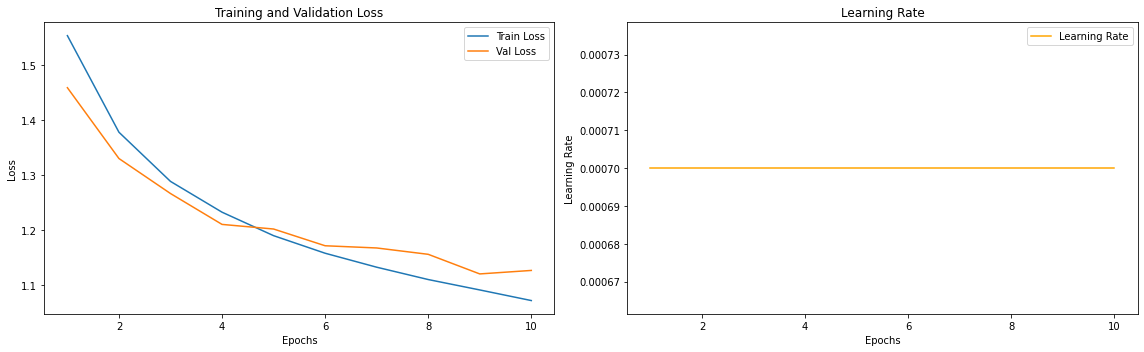

In [62]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = EPOCHS
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

In [63]:
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

In [18]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

(build_single_tfrecord pid=421) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords
슝=3


In [19]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [20]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [21]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [22]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


### STEP 1 : simplebaseline 모델 완성하기
---
simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

In [23]:
def _make_deconv_layer(num_deconv_layers):
    """
    Deconvolution Layer를 생성합니다.
    Args:
        num_deconv_layers: Deconvolution 레이어의 개수
    Returns:
        Sequential model containing the deconv layers
    """
    seq_model = tf.keras.models.Sequential()

    # [[YOUR CODE]]
    for i in range(num_deconv_layers):
        # 디컨볼루션 레이어 추가
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        
        # Batch Normalization
        seq_model.add(tf.keras.layers.BatchNormalization())
        
        # ReLU 활성화 함수
        seq_model.add(tf.keras.layers.ReLU())
    
    return seq_model

In [24]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

epochs = EPOCHS
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [25]:
upconv = _make_deconv_layer(3)

# [[YOUR CODE]]
final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')

In [26]:
# Simplebaseline에서 resnet을 불러올 때 함수 바깥에서 불러오면 
# resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

### 아래 에러 발생함
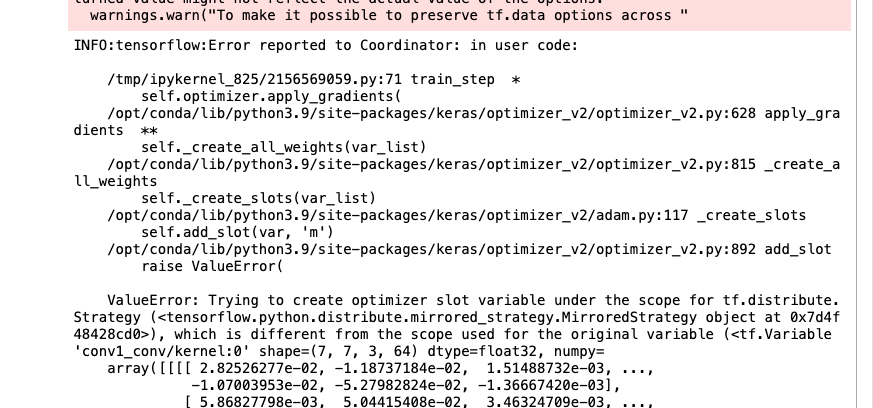

In [27]:
def Simplebaseline(input_shape=(256, 256, 3)):
    # Simplebaseline에서 resnet을 불러올 때 함수 바깥에서 불러와서 발생하는 문제
    # resnet을 불러올 때 함수 내부에서 불러오면 정상적으로 학습
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNet50을 통과
    x = resnet(inputs)
    
    # 디컨볼루션 레이어를 통과
    x = upconv(x)
    
    # 최종 컨볼루션 레이어를 통과하여 히트맵 생성
    out = final_layer(x)
    
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [28]:
# spb_model = Simplebaseline(IMAGE_SHAPE)
# spb_model.summary()

### STEP 2 : simplebaseline 모델로 변경하여 훈련하기
---
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

### 아래와 같은 문제가 발생하여 디버깅 
- 발생 에러
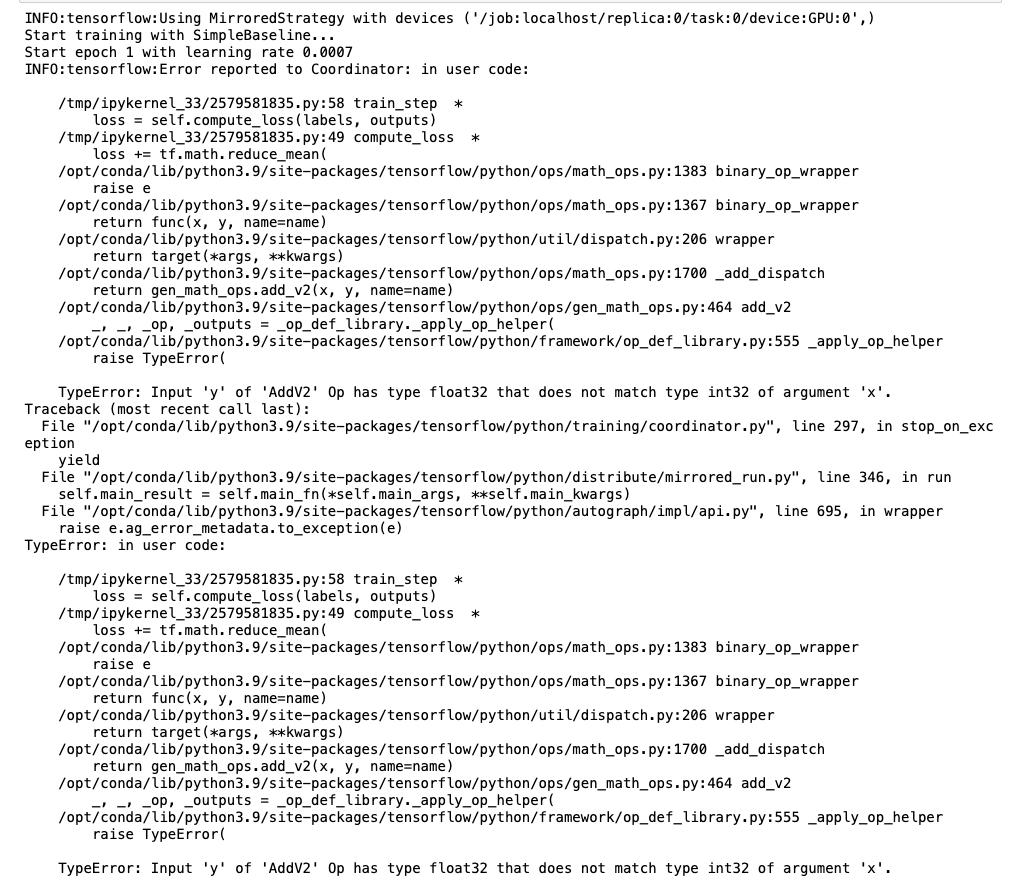

- 디버깅 과정  

1. SimpleBaseline 모델 출력 확인
    ```python
    sample_input = tf.random.normal((1, 256, 256, 3))
    sample_output = spb_model(sample_input)
    print(f"Model output dtype: {sample_output.dtype}, shape: {sample_output.shape}")
    ```
    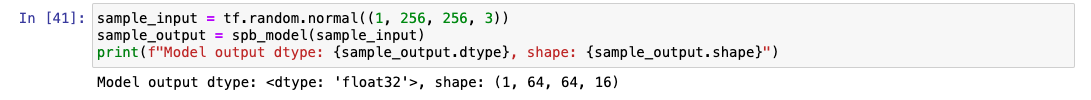
    - 데이터 타입: float32 ✅ 정상
    - 출력 형태: (1, 64, 64, 16) ✅ 정상  


2. 데이터셋 확인 결과
    ```python
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
            train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    for images, labels in train_dataset.take(1):
        print(f"Labels dtype: {labels.dtype}, shape: {labels.shape}")
        print(f"Images dtype: {images.dtype}, shape: {images.shape}")
    ```
    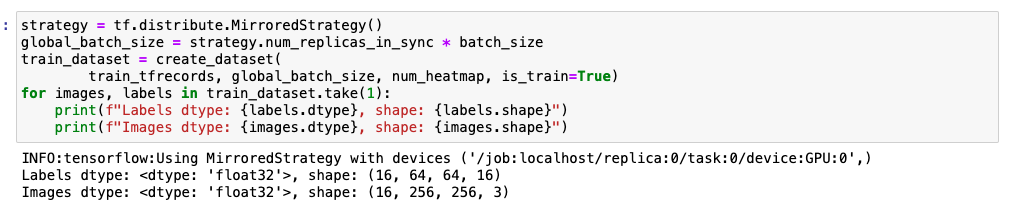
    - labels dtype: float32 → ✅ 정상
    - labels shape: (16, 64, 64, 16) → ✅ outputs와 동일
    - images dtype: float32 → ✅ 정상
    - images shape: (16, 256, 256, 3) → ✅ 정상  


3. compute_loss 의 SimpleBaseline에 맞게 outputs가 단일 텐서일 경우도 처리하도록 코드를 보완
    - Hourglass 모델 출력: 여러 단계에서 히트맵이 출력됨 → outputs는 리스트 형태로 여러 히트맵을 포함
    - SimpleBaseline 모델 출력: 마지막 히트맵만 출력됨 → outputs는 단일 텐서

In [29]:
def spb_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # 데이터셋 준비
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_CUSTOM_PATH):
        os.makedirs(MODEL_CUSTOM_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # 변경된 부분: StackedHourglass 대신 SimpleBaseline 사용
        spb_model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            spb_model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate
        )

        print('Start training with SimpleBaseline...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 0.574358165 epoch total loss 0.574358165
Trained batch 2 batch loss 0.641477346 epoch total loss 0.607917786
Trained batch 3 batch loss 0.521326065 epoch total loss 0.579053879
Trained batch 4 batch loss 0.478004694 epoch total loss 0.553791583
Trained batch 5 batch loss 0.486471891 epoch total loss 0.540327668
Trained batch 6 batch loss 0.471382439 epoch total loss 0.528836787
Trained batch 7 batch loss 0.444877297 epoch total loss 0.516842544
Trained batch 8 batch loss 0.43722713 epoch total loss 0.506890655
Trained batch 9 batch loss 0.443704695 epoch total loss 0.499869972
Trained batch 10 batch loss 0.430780381 epoch total loss 0.492961019
Trained batch 11 batch loss 0.390804589 epoch total loss 0.483674079
Trained batch 12 batch loss 0.402380496 epoch total loss 0.476899624
Trained batch 13 batch loss 0.424289882 epoch total loss 0.472852707
Trained batch 14 batch loss 0.410904944 epoch total loss 0.468427867
Trained batch

Trained batch 120 batch loss 0.371392101 epoch total loss 0.399210185
Trained batch 121 batch loss 0.365860343 epoch total loss 0.398934573
Trained batch 122 batch loss 0.36641115 epoch total loss 0.398668
Trained batch 123 batch loss 0.379647464 epoch total loss 0.398513317
Trained batch 124 batch loss 0.340866089 epoch total loss 0.398048431
Trained batch 125 batch loss 0.383311868 epoch total loss 0.397930533
Trained batch 126 batch loss 0.373931 epoch total loss 0.397740066
Trained batch 127 batch loss 0.366967 epoch total loss 0.397497773
Trained batch 128 batch loss 0.377598375 epoch total loss 0.397342294
Trained batch 129 batch loss 0.384108394 epoch total loss 0.397239715
Trained batch 130 batch loss 0.388163596 epoch total loss 0.397169918
Trained batch 131 batch loss 0.352431297 epoch total loss 0.396828383
Trained batch 132 batch loss 0.374971211 epoch total loss 0.396662802
Trained batch 133 batch loss 0.351361156 epoch total loss 0.396322191
Trained batch 134 batch loss 0

Trained batch 238 batch loss 0.362667412 epoch total loss 0.381757855
Trained batch 239 batch loss 0.354296893 epoch total loss 0.381642938
Trained batch 240 batch loss 0.344861507 epoch total loss 0.381489694
Trained batch 241 batch loss 0.324005932 epoch total loss 0.381251156
Trained batch 242 batch loss 0.298340619 epoch total loss 0.380908549
Trained batch 243 batch loss 0.318634748 epoch total loss 0.380652279
Trained batch 244 batch loss 0.330207 epoch total loss 0.38044554
Trained batch 245 batch loss 0.337171525 epoch total loss 0.380268931
Trained batch 246 batch loss 0.35223797 epoch total loss 0.380155
Trained batch 247 batch loss 0.33927 epoch total loss 0.379989475
Trained batch 248 batch loss 0.336393952 epoch total loss 0.379813701
Trained batch 249 batch loss 0.360125363 epoch total loss 0.379734606
Trained batch 250 batch loss 0.351286799 epoch total loss 0.37962082
Trained batch 251 batch loss 0.347938389 epoch total loss 0.379494607
Trained batch 252 batch loss 0.35

Trained batch 356 batch loss 0.364063829 epoch total loss 0.369897395
Trained batch 357 batch loss 0.349671334 epoch total loss 0.369840741
Trained batch 358 batch loss 0.35115543 epoch total loss 0.369788527
Trained batch 359 batch loss 0.369642705 epoch total loss 0.36978811
Trained batch 360 batch loss 0.360019743 epoch total loss 0.369761
Trained batch 361 batch loss 0.356117964 epoch total loss 0.369723201
Trained batch 362 batch loss 0.375448346 epoch total loss 0.369739
Trained batch 363 batch loss 0.347379565 epoch total loss 0.369677424
Trained batch 364 batch loss 0.369185448 epoch total loss 0.369676054
Trained batch 365 batch loss 0.351168275 epoch total loss 0.36962536
Trained batch 366 batch loss 0.344021142 epoch total loss 0.369555414
Trained batch 367 batch loss 0.296522856 epoch total loss 0.369356424
Trained batch 368 batch loss 0.356814384 epoch total loss 0.36932233
Trained batch 369 batch loss 0.356661528 epoch total loss 0.369288
Trained batch 370 batch loss 0.33

Trained batch 474 batch loss 0.360433966 epoch total loss 0.363399386
Trained batch 475 batch loss 0.327192336 epoch total loss 0.363323182
Trained batch 476 batch loss 0.326934457 epoch total loss 0.363246739
Trained batch 477 batch loss 0.320946932 epoch total loss 0.363158047
Trained batch 478 batch loss 0.347824425 epoch total loss 0.36312598
Trained batch 479 batch loss 0.334747076 epoch total loss 0.363066733
Trained batch 480 batch loss 0.350956231 epoch total loss 0.36304149
Trained batch 481 batch loss 0.351254582 epoch total loss 0.363017
Trained batch 482 batch loss 0.350781083 epoch total loss 0.362991631
Trained batch 483 batch loss 0.328419447 epoch total loss 0.362920016
Trained batch 484 batch loss 0.332875818 epoch total loss 0.362857938
Trained batch 485 batch loss 0.353312075 epoch total loss 0.362838268
Trained batch 486 batch loss 0.328781694 epoch total loss 0.362768203
Trained batch 487 batch loss 0.330778509 epoch total loss 0.362702519
Trained batch 488 batch l

Trained batch 592 batch loss 0.345192313 epoch total loss 0.358177632
Trained batch 593 batch loss 0.334792793 epoch total loss 0.358138204
Trained batch 594 batch loss 0.340915084 epoch total loss 0.358109176
Trained batch 595 batch loss 0.327263117 epoch total loss 0.35805735
Trained batch 596 batch loss 0.301911086 epoch total loss 0.357963145
Trained batch 597 batch loss 0.351663768 epoch total loss 0.357952625
Trained batch 598 batch loss 0.381250441 epoch total loss 0.357991576
Trained batch 599 batch loss 0.346968 epoch total loss 0.357973188
Trained batch 600 batch loss 0.345520437 epoch total loss 0.357952416
Trained batch 601 batch loss 0.294024676 epoch total loss 0.357846051
Trained batch 602 batch loss 0.305247128 epoch total loss 0.357758671
Trained batch 603 batch loss 0.322228551 epoch total loss 0.357699782
Trained batch 604 batch loss 0.321005553 epoch total loss 0.357639
Trained batch 605 batch loss 0.301869541 epoch total loss 0.357546806
Trained batch 606 batch los

Trained batch 710 batch loss 0.325458497 epoch total loss 0.353862435
Trained batch 711 batch loss 0.337167 epoch total loss 0.35383895
Trained batch 712 batch loss 0.352155924 epoch total loss 0.353836596
Trained batch 713 batch loss 0.315586448 epoch total loss 0.353782952
Trained batch 714 batch loss 0.380671084 epoch total loss 0.353820622
Trained batch 715 batch loss 0.406353 epoch total loss 0.353894085
Trained batch 716 batch loss 0.339954317 epoch total loss 0.353874624
Trained batch 717 batch loss 0.331267178 epoch total loss 0.353843093
Trained batch 718 batch loss 0.358614802 epoch total loss 0.353849739
Trained batch 719 batch loss 0.349582523 epoch total loss 0.353843778
Trained batch 720 batch loss 0.366608799 epoch total loss 0.353861511
Trained batch 721 batch loss 0.321712077 epoch total loss 0.353816926
Trained batch 722 batch loss 0.344518512 epoch total loss 0.353804052
Trained batch 723 batch loss 0.325649649 epoch total loss 0.3537651
Trained batch 724 batch loss 

Trained batch 828 batch loss 0.342497736 epoch total loss 0.350105911
Trained batch 829 batch loss 0.332380593 epoch total loss 0.350084513
Trained batch 830 batch loss 0.34063822 epoch total loss 0.350073129
Trained batch 831 batch loss 0.328805268 epoch total loss 0.350047529
Trained batch 832 batch loss 0.332202464 epoch total loss 0.350026101
Trained batch 833 batch loss 0.334447563 epoch total loss 0.350007385
Trained batch 834 batch loss 0.344524145 epoch total loss 0.350000799
Trained batch 835 batch loss 0.328843594 epoch total loss 0.349975467
Trained batch 836 batch loss 0.35095346 epoch total loss 0.349976659
Trained batch 837 batch loss 0.304705352 epoch total loss 0.349922568
Trained batch 838 batch loss 0.290216386 epoch total loss 0.34985134
Trained batch 839 batch loss 0.345468819 epoch total loss 0.349846095
Trained batch 840 batch loss 0.311597168 epoch total loss 0.349800557
Trained batch 841 batch loss 0.349514127 epoch total loss 0.349800199
Trained batch 842 batch

Trained batch 946 batch loss 0.337818 epoch total loss 0.346595019
Trained batch 947 batch loss 0.338553816 epoch total loss 0.346586525
Trained batch 948 batch loss 0.335296661 epoch total loss 0.346574605
Trained batch 949 batch loss 0.337432086 epoch total loss 0.346564978
Trained batch 950 batch loss 0.352369547 epoch total loss 0.346571088
Trained batch 951 batch loss 0.333968878 epoch total loss 0.346557796
Trained batch 952 batch loss 0.344277084 epoch total loss 0.346555412
Trained batch 953 batch loss 0.336485207 epoch total loss 0.346544832
Trained batch 954 batch loss 0.308103621 epoch total loss 0.346504539
Trained batch 955 batch loss 0.325231165 epoch total loss 0.346482277
Trained batch 956 batch loss 0.296470284 epoch total loss 0.346429974
Trained batch 957 batch loss 0.303340554 epoch total loss 0.346384943
Trained batch 958 batch loss 0.324258685 epoch total loss 0.346361846
Trained batch 959 batch loss 0.330824196 epoch total loss 0.346345603
Trained batch 960 batch

Trained batch 1063 batch loss 0.296676874 epoch total loss 0.343978643
Trained batch 1064 batch loss 0.30256623 epoch total loss 0.343939692
Trained batch 1065 batch loss 0.317397922 epoch total loss 0.343914777
Trained batch 1066 batch loss 0.284091502 epoch total loss 0.343858629
Trained batch 1067 batch loss 0.308559626 epoch total loss 0.343825579
Trained batch 1068 batch loss 0.288602889 epoch total loss 0.343773872
Trained batch 1069 batch loss 0.285055876 epoch total loss 0.343718946
Trained batch 1070 batch loss 0.298696607 epoch total loss 0.343676865
Trained batch 1071 batch loss 0.319245577 epoch total loss 0.343654066
Trained batch 1072 batch loss 0.306957066 epoch total loss 0.343619823
Trained batch 1073 batch loss 0.290545881 epoch total loss 0.343570352
Trained batch 1074 batch loss 0.315252393 epoch total loss 0.343544
Trained batch 1075 batch loss 0.285853148 epoch total loss 0.343490332
Trained batch 1076 batch loss 0.327081233 epoch total loss 0.343475074
Trained ba

Trained batch 1180 batch loss 0.365735382 epoch total loss 0.342219651
Trained batch 1181 batch loss 0.365851134 epoch total loss 0.342239648
Trained batch 1182 batch loss 0.354261696 epoch total loss 0.342249811
Trained batch 1183 batch loss 0.345245957 epoch total loss 0.342252344
Trained batch 1184 batch loss 0.335579276 epoch total loss 0.342246711
Trained batch 1185 batch loss 0.294048399 epoch total loss 0.342206031
Trained batch 1186 batch loss 0.300415248 epoch total loss 0.342170775
Trained batch 1187 batch loss 0.309810132 epoch total loss 0.342143536
Trained batch 1188 batch loss 0.328304768 epoch total loss 0.342131883
Trained batch 1189 batch loss 0.323919654 epoch total loss 0.342116565
Trained batch 1190 batch loss 0.361937702 epoch total loss 0.342133224
Trained batch 1191 batch loss 0.338107944 epoch total loss 0.342129827
Trained batch 1192 batch loss 0.320145547 epoch total loss 0.342111409
Trained batch 1193 batch loss 0.340005755 epoch total loss 0.342109621
Traine

Trained batch 1296 batch loss 0.338395 epoch total loss 0.340238184
Trained batch 1297 batch loss 0.318635225 epoch total loss 0.340221524
Trained batch 1298 batch loss 0.320457608 epoch total loss 0.340206295
Trained batch 1299 batch loss 0.304634452 epoch total loss 0.340178907
Trained batch 1300 batch loss 0.303376913 epoch total loss 0.340150595
Trained batch 1301 batch loss 0.324723721 epoch total loss 0.340138733
Trained batch 1302 batch loss 0.360198826 epoch total loss 0.340154141
Trained batch 1303 batch loss 0.345671356 epoch total loss 0.340158373
Trained batch 1304 batch loss 0.32602191 epoch total loss 0.340147555
Trained batch 1305 batch loss 0.354530752 epoch total loss 0.340158552
Trained batch 1306 batch loss 0.360820413 epoch total loss 0.340174377
Trained batch 1307 batch loss 0.349512219 epoch total loss 0.34018153
Trained batch 1308 batch loss 0.299547315 epoch total loss 0.340150476
Trained batch 1309 batch loss 0.299632907 epoch total loss 0.340119511
Trained bat

Validated batch 40 batch loss 0.325187653
Validated batch 41 batch loss 0.292717338
Validated batch 42 batch loss 0.329502106
Validated batch 43 batch loss 0.355540901
Validated batch 44 batch loss 0.342310756
Validated batch 45 batch loss 0.317922771
Validated batch 46 batch loss 0.306401163
Validated batch 47 batch loss 0.328202426
Validated batch 48 batch loss 0.334705085
Validated batch 49 batch loss 0.322755635
Validated batch 50 batch loss 0.314972758
Validated batch 51 batch loss 0.338655651
Validated batch 52 batch loss 0.36359635
Validated batch 53 batch loss 0.312718958
Validated batch 54 batch loss 0.338391215
Validated batch 55 batch loss 0.324153513
Validated batch 56 batch loss 0.335233271
Validated batch 57 batch loss 0.318318069
Validated batch 58 batch loss 0.298890382
Validated batch 59 batch loss 0.36210081
Validated batch 60 batch loss 0.321169972
Validated batch 61 batch loss 0.350865513
Validated batch 62 batch loss 0.322387934
Validated batch 63 batch loss 0.3422

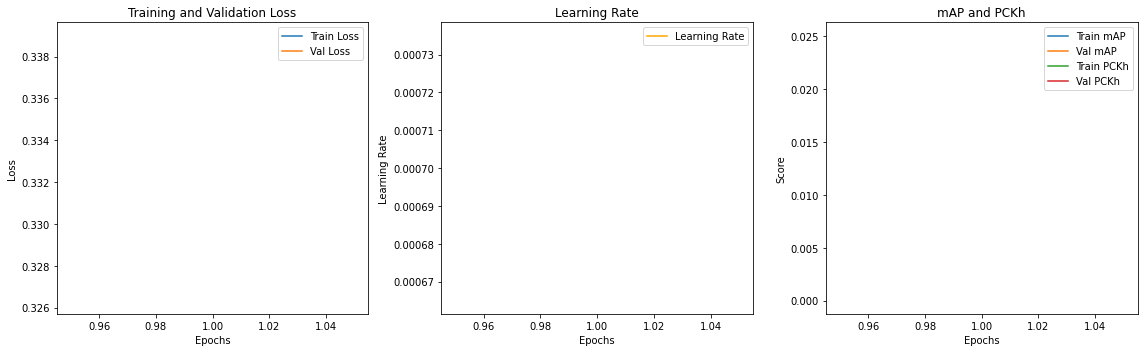

In [30]:
best_spb_model_file = spb_train(
    epochs=epochs,
    learning_rate=learning_rate,
    num_heatmap=num_heatmap,
    batch_size=batch_size,
    train_tfrecords=train_tfrecords,
    val_tfrecords=val_tfrecords
)

In [31]:
spb_model = Simplebaseline(IMAGE_SHAPE)
spb_model.load_weights(best_spb_model_file)

### STEP 3 : 두 모델의 비교
---
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)  

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

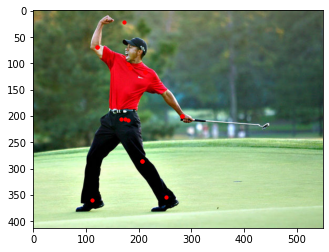

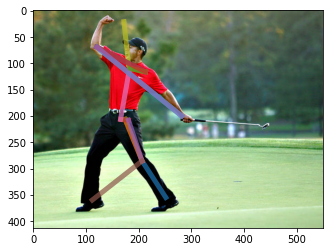

In [64]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

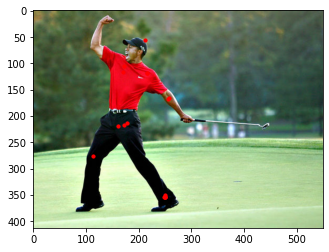

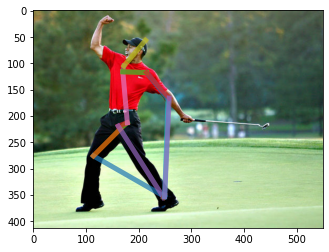

In [32]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(spb_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### Test 결과 기록
---

- 각 모델 1 epoch 결과
    - StackedHourglass Network
    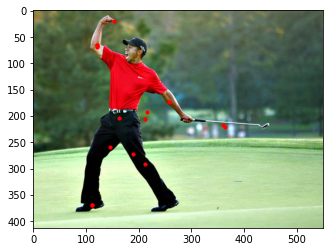
    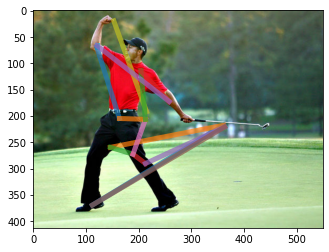  
    
    - Simplebaseline  
    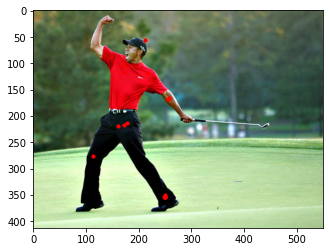
    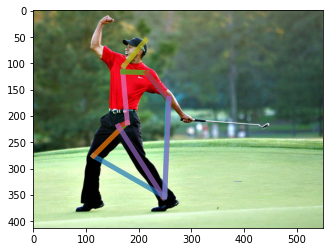

- 각 모델 10 epoch 결과
    - StackedHourglass Network
    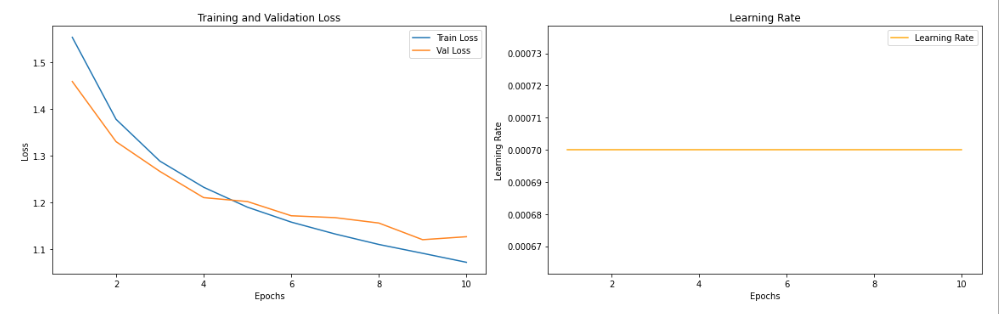
    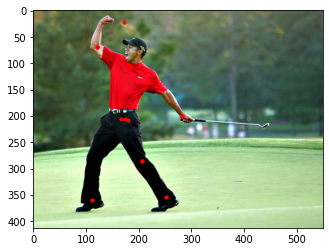
    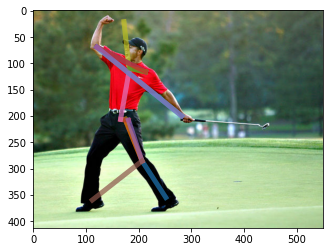
    
    - Simplebaseline  


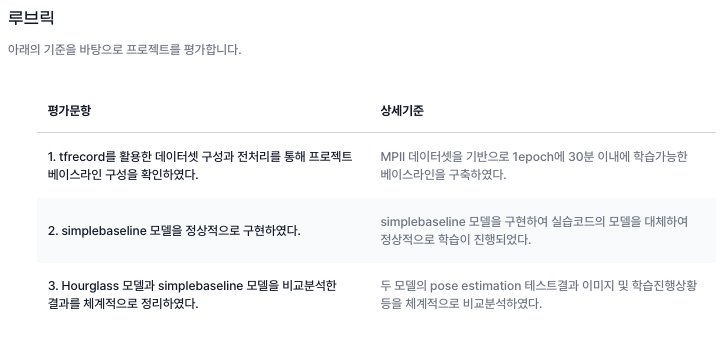